# Orbital Mechanics with Orekit 

**Western Sydney University** The MARCS Institute for Brain, Behaviour and Development, Biomedical Engineering and Neuromorphic Systems (BENS) 







This notebook is based on the following:

**Orekit jupyter notebooks**

 - http://nbviewer.jupyter.org/urls/www.orekit.org/forge/projects/orekit-python-wrapper/repository/revisions/master/raw/examples/orekit%20map.ipynb

 - http://nbviewer.jupyter.org/urls/www.orekit.org/forge/projects/orekit-python-wrapper/repository/revisions/master/raw/examples/TLE%20Propagation.ipynb?create=1

**Orekit Gitlab jupyter notebooks**

 - https://gitlab.orekit.org/orekit-labs/python-wrapper/blob/master/examples/orekit_map.ipynb

 - https://gitlab.orekit.org/orekit-labs/python-wrapper/blob/master/examples/Example_EarthObservation_-_Attitude_Sequence.ipynb

 - https://gitlab.orekit.org/orekit-labs/python-wrapper/blob/master/examples/Example_numerical_prop.ipynb

 - https://gitlab.orekit.org/orekit-labs/python-wrapper/blob/master/examples/NodeDetectorTest.py

 - https://gitlab.orekit.org/orekit-labs/python-wrapper/blob/master/examples/TLE_Propagation.ipynb

**Orekit main resources and function reference** 

 - https://www.orekit.org/static/apidocs/overview-summary.html

 - https://www.orekit.org/static/apidocs/org/orekit/frames/FramesFactory.html#EOPC04_2000_FILENAME



**Install Orekit using Anaconda:**

>conda create -n orekit python=3.6


 - Orekit can be installed with one of the following:

>conda install -c conda-forge orekit
>conda install -c conda-forge/label/gcc7 orekit
>conda install -c conda-forge/label/broken orekit 


 - For the fancy earth map overlays, install mpl_toolkits.basemap using:

>conda install basemap 
>conda install ioos geopandas 
>conda install conda-forge proj4

 - For 3D projection of orbit:

>conda install plotly


**Basic use and installation of Orekit**

The orekit library needs a data file with various information on time and earth rotation parameters. This file, called orekit-data.zip is loaded from current dir. 

A basic version of this file can be downloaded from the orekit webpage:
https://www.orekit.org/forge/projects/orekit/files
called "orekit-data.zip"

Place this in the directory of the notebook

This routine is commonly used in the notebooks, so a python specific function is created for this, setup_orekit_curdir()




In [146]:
#orekit python wrapper library and resources 
import orekit
orekit.initVM()

from orekit.pyhelpers import setup_orekit_curdir
setup_orekit_curdir()

from org.orekit.data import DataProvidersManager, ZipJarCrawler
from org.orekit.frames import FramesFactory, TopocentricFrame, EOPEntry, EOPHistoryLoader
from org.orekit.bodies import OneAxisEllipsoid, GeodeticPoint
from org.orekit.time import TimeScalesFactory, AbsoluteDate, DateComponents, TimeComponents
from org.orekit.utils import IERSConventions, Constants

from org.orekit.propagation.analytical.tle import TLE, TLEPropagator
from org.orekit.propagation.analytical.gnss import GPSPropagator

from org.orekit.estimation.measurements import AngularAzEl

from java.io import File

In [147]:
#basic utilities
import numpy as np
from math import radians, pi

#tabulating 
import pandas as pd 
import geopandas

#plotting imports 
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

#plotting import basemap for detailed map figures 
from mpl_toolkits.basemap import Basemap
from mpl_toolkits import mplot3d

#plotting plotly for 3D figure of propogated orbit 
from plotly import __version__
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


# Define the TLE of an object 

The **Two Line Element** of an object or **TLE**, is a data format encoding a list of orbital elements of an Earth-orbiting object for a given point or epoch in time. 

 - Using suitable prediction formula, the state (position and velocity) at any point in the past or future can be estimated to some accuracy. 

- The TLE data representation is specific to the simplified perturbations models (SGP, SGP4, SDP4, SGP8 and SDP8), so any algorithm using a TLE as a data source must implement one of the SGP models to correctly compute the state at a time of interest. 

- TLEs can describe the trajectories only of Earth-orbiting objects and are widely used as input for projecting the future orbital tracks 
 
Summarised from: https://en.wikipedia.org/wiki/Two-line_element_set


**TLEs follows a strict format:**

AAAAAAAAAAAAAAAAAAAAAAAA
 - 1 NNNNNU NNNNNAAA NNNNN.NNNNNNNN +.NNNNNNNN +NNNNN-N +NNNNN-N N NNNNN
 - 2 NNNNN NNN.NNNN NNN.NNNN NNNNNNN NNN.NNNN NNN.NNNN NN.NNNNNNNNNNNNNN

Line 0 is a twenty-four character name (to be consistent with the name length in the NORAD SATCAT).

Lines 1 and 2 are the standard Two-Line Orbital Element Set Format identical to that used by NORAD and NASA. The format description is:


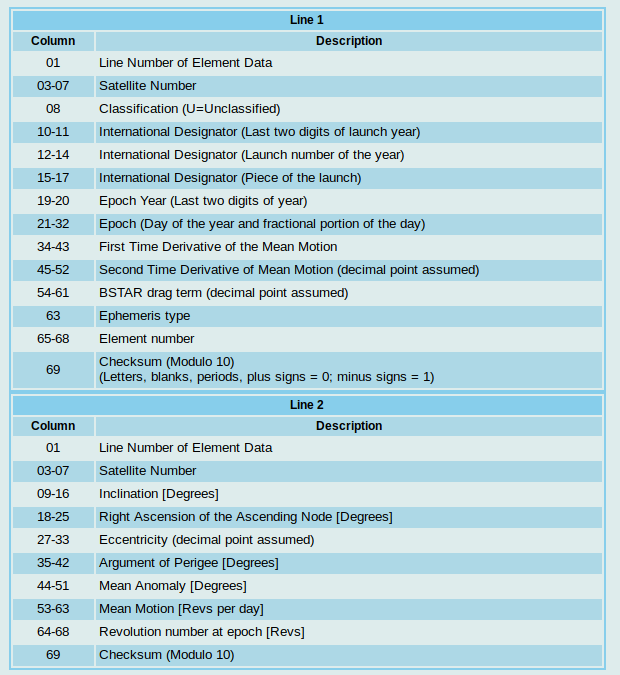

Image Source: https://www.celestrak.com/NORAD/elements/

Up to date TLE's of prominant objects can be found at:
https://www.celestrak.com/NORAD/elements/stations.txt


In [166]:
#define the TLE of the ISS and the NOAA 20 (JPSS 1)

#Zarya - ISS 
tle_line1 = '1 25544U 98067A   18316.88896991  .00002947  00000-0  52056-4 0  9991'
tle_line2 = '2 25544  51.6422 357.6931 0005136  41.3112 314.7205 15.53960178141635'


# NOAA 20 (JPSS 1) 
# tle_line1 = '1 43013U 17073A   18312.57095080  .00000002  00000-0  21864-4 0  9995'
# tle_line2 = '2 43013  98.7377 248.8238 0001064 105.4327 254.6967 14.19551187 50390'


In [167]:
#Parse the TLE lines to a orekit TLE object 
zarya = TLE(tle_line1,tle_line2)

#print the TLE object and epoch data 
print('TLE Lines 1 and 2:\n')

print(zarya)
 
print('\nEpoch :',zarya.getDate())

TLE Lines 1 and 2:

1 25544U 98067A   18316.88896991  .00002947  00000-0  52056-4 0  9991
2 25544  51.6422 357.6931 0005136  41.3112 314.7205 15.53960178141635

Epoch : 2018-11-12T21:20:07.000


# Specify the location of the observing station


**Earth-centered inertial (ECI)** coordinate frames have their origins at the center of mass of Earth and do not rotate with respect to the stars. 


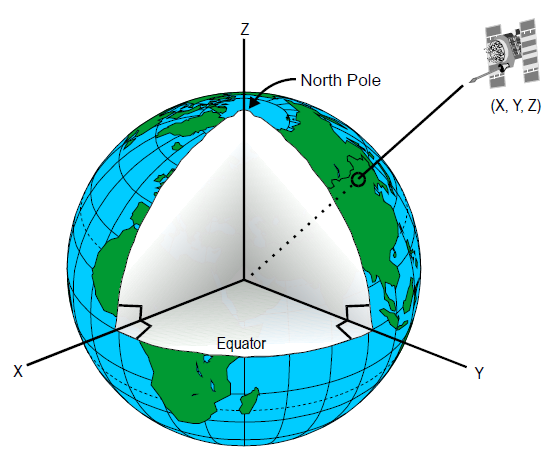


Image source: https://en.wikipedia.org/wiki/Earth-centered_inertial


The most current interpretation is the **International Terrestrial Reference Frame (ITRF)**
This is the current (as of 2013) reference produced by IERS. It is described in IERS conventions (2010). 

This frame utilises a set of **Earth Orientation Parameters (EOP)**, as a collection of parameters that describe irregularities in the rotation of the Earth. 


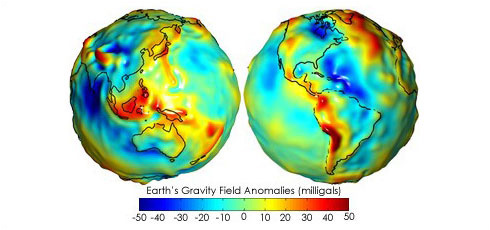


Image Source: http://deacademic.com/dic.nsf/dewiki/1558295


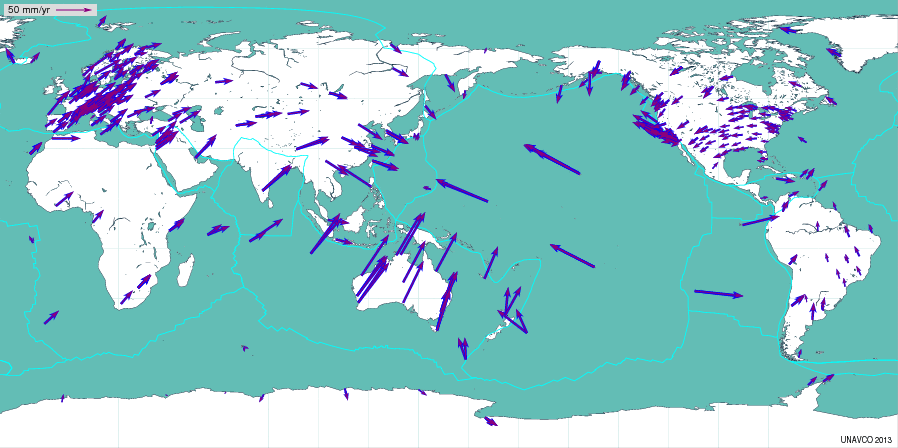


Image Source: https://spotlight.unavco.org/how-gps-works/gps-basics/gps-reference-frames.html




The ITRF replaces the **Earth Centered Earth Fixed frame (ECEF)** as a geographic and Cartesian coordinate system and is sometimes known as a **"conventional terrestrial system"**, which is the reference frame for GPS satellites.
 
It represents positions as X, Y, and Z coordinates. The point (0, 0, 0) is defined as the center of mass of Earth, hence the term geocentric coordinates. 


 - J2000
  -  One commonly used ECI frame is defined with the Earth's Mean Equator and Equinox at 12:00 Terrestrial Time on 1 January 2000. It can be referred to as J2000 or EME2000. The x-axis is aligned with the mean equinox. The z-axis is aligned with the Earth's spin axis or celestial North Pole. The y-axis is rotated by 90° East about the celestial equator.


 - M50
  -  This frame is similar to J2000, but is defined with the mean equator and equinox at 12:00 on 1 January 1950.


 - GCRF
  -  Geocentric Celestial Reference Frame (GCRF) is the Earth-centered counterpart of the International Celestial Reference Frame.


 - MOD
  -  A Mean of Date (MOD) frame is defined using the mean equator and equinox on a particular date.


 - TEME
  -  The ECI frame used for the NORAD two-line elements is sometimes called true equator, mean equinox (TEME) although it does not use the conventional mean equinox. 


Source: https://en.wikipedia.org/wiki/ECEF#In_astronomy


In [153]:
#get the earth ITRF
ITRF = FramesFactory.getITRF(IERSConventions.IERS_2010, True)

#create an Orekit Ellipsoid object for Earth using the defined ITRF, equatorial radius and flattenting constants 
earth = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS, 
                         Constants.WGS84_EARTH_FLATTENING, 
                         ITRF)

# Define the geographic and geodetic corrdinates of the observating station

The geographic corridnates are in terms of latitude, longitiude and altitude (m).

Latitude and Longitude here are defined using decimal degrees (DD), not Hours/Degrees Minutes Seconds(HMS), which are converted to radians. 

We convert these from **geographic** to **geodetic** coordinates. 

In geodetic coordinates, the Earth's surface is approximated by an ellipsoid, and locations near the surface are also described in terms of latitude, longitude and height. 

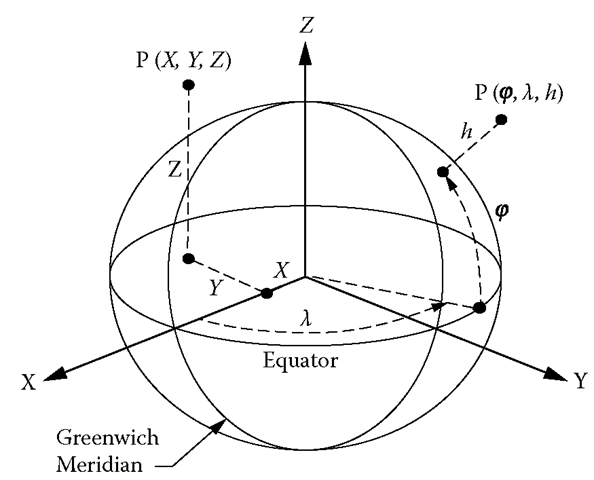

Image Source: https://au.mathworks.com/matlabcentral/fileexchange/61958-geodetic-coordinates

Then we convert to the **topocentric** or "horizontal" coordinate system. This is a celestial coordinate system that uses the observer's local horizon as the fundamental plane. 

Coordinates of an object in the sky are expressed in terms of altitude (or elevation) angle and azimuth. This is often called **Az-El**, as Azimuth-Elevation.  


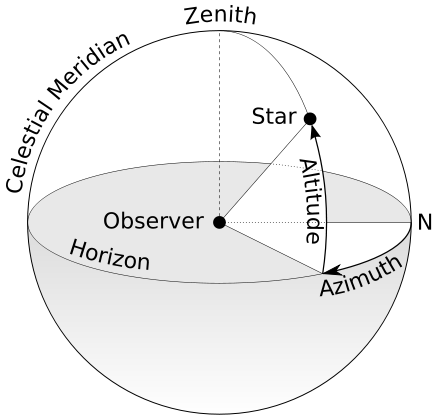

Image Source: https://en.wikipedia.org/wiki/Horizontal_coordinate_system



In [154]:
#WSU werrington observatory position in the geographic coordinate frame

longitude = radians(-33.4543)  #radians(DD)
latitude  = radians(150.4428)  #radians(DD)
altitude  = 56.0               #Elevation (m)

#convert from the geographic coordinates to geodetic corrdinates
station_wsu_geod = GeodeticPoint(latitude, longitude, altitude)

#convert from the geodetic to the topocentric coordinate frame 
station_wsu_topoframe = TopocentricFrame(earth, station_wsu_geod, "Esrange")


# Time Standards and Systems





There are several time standards and systems currently in use:


 - TAI International Atomic Time: Primary time standard in the world today.


 - UTC Coordinated Universal Time: 
  - Time broadcast by WWV and other services. By definition, UTC and TAI have the same rate but UTC stays close to Mean Solar Time by adding integer numbers of seconds, called leap seconds,from time to time.
  -  UTC is related to TAI using step adjustments from time to time according to IERS (International Earth Rotation Service) rules. These adjustments require introduction of leap seconds. Some leaps are already known and predefined in the library (at least from 1972-01-01 to 2009-01-01) and other ones can be supported by providing UTC-TAI.history files using the data loading mechanism provided by DataProvidersManager
    
    
 - TDT or TT - Terrestrial Dynamic Time
  -  Terrestrial Time as defined by IAU(1991) recommendation IV. Coordinate time at the surface of the Earth. It is the successor of Ephemeris Time TE. By convention, TT = TAI + 32.184 s. Tied to atomic time by a constant offset of 32.184 seconds, replaced ET at the beginning of 1984. Before atomic clocks, Ephemeris Time (ET) was the closest available approximation to a uniform time for planetary motion calculations. 


 - TDB - Barycentric Dynamic Time
  -  Barycentric Dynamic Time (TDB) is the same as as Terrestrial Dynamic Time (TT) except for relativistic corrections to move the origin to the solar system barycenter. Time used to compute ephemerides in the solar system. This time is offset with respect to TT by small relativistic corrections due to Earth motion,


 - TCG: Geocentric Coordinate Time. Coordinate time at the center of mass of the Earth. This time scale depends linearly on TTScale,

    
 - TCBScale: Barycentric Coordinate Time. Coordinate time used for computations in the solar system. This time scale depends linearly on TDBScale,
    
    
 - GPSScale: Global Positioning System reference scale. This scale was equal to UTC at start of the GPS Epoch when it was 19 seconds behind TAI, and remained parallel to TAI since then (i.e. UTC is now offset from GPS due to leap seconds). TGPS = TAI - 19 s,
    
    

**Earth Rotation Times**

 - UT1 - Universal Time
  -  Universal Time (UT1) is a measure of the actual rotation of the earth, independent of observing location. UT1 is essentially the same as the now discontinued Greenwich Mean Time (GMT)
  -  Universal Time 1. UT1 is a time scale directly linked to the actual rotation of the Earth. It is an irregular scale, reflecting Earth irregular rotation rate. The offset between UT1 and UTCScale is found in the Earth Orientation Parameters published by IERS,
    

 - UT0 (UT-zero)
  -  An observatory-specific version of UT1 in the sense that UT0 contains the effect of polar motion on the observed rotation of the earth. Polar motion is equivalent to a change in latitude and longitude of points on the earth's surface with respect to the earth's instantaneous rotation axis


 - UT2, appears to be of mostly historical interest.


 - GMST - Greenwich Mean Sidereal Time
  -  Greenwich Mean Sidereal Time scale. The Greenwich Mean Sidereal Time is the hour angle between the meridian of Greenwich and mean equinox of date at 0h UT1.
  -  Sidereal time is the measure of the earth's rotation with respect to distant celestial objects. Compare this to UT1, which is the rotation of the earth with respect to the mean position of the sun. One sidereal second is approximately 365.25/366.25 of a UT1 second. In other words, there is one more day in a sidereal year than in a solar year. 


 - GAST - Greenwich Apparent Sidereal Time
  -  Time (GMST) corrected for the shift in the position of the vernal equinox due to nutation. Nutation is the mathematically predictable change in the direction of the earth's axis of rotation due to changing external torques from the sun, moon and planets.


 - LMST - Local Mean Sidereal Time
  -  Local Mean Sidereal time is GMST plus the observer's longitude measured positive to the east of Greenwich.


 - LST - Local Sidereal Time
  -  The definition of Local Sidereal Time given in the glossary of the Explanatory Supplement to the Astronomical Almanac is "the local hour angle of a catalog equinox."



    


Source: https://www.cv.nrao.edu/~rfisher/Ephemerides/times.html








In [156]:
#create the time array for propogation, 
# from initial epoch to final with intervals of 10 seconds 

#specify current date for propogatation 
current_date_year = 2018
current_date_month = 11
current_date_day = 12
current_date_hour = 12
current_date_minute = 11
current_date_seconds = 00.000

#create an absoluteDate object for the initial date in UTC,
# from specified current year, month and day
initial_date = AbsoluteDate(DateComponents(current_date_year,
                                          current_date_month,
                                          current_date_day),
                           TimeComponents.H00,
                           TimeScalesFactory.getUTC())

#extrapolate initial date by 24 hours (as seconds)
extrapolated_date = initial_date;
shift_time = 60.0*60*24 #seconds
step_time = 10 #seconds 
final_date = extrapolated_date.shiftedBy(shift_time)


#print out each date and shift time 
print('Initial Date:\n',initial_date)

print('\nFinal Date (Propogated):\n',final_date)

print('\nShifted by',shift_time,'Seconds or',(shift_time/60/60),'Hours')



Initial Date:
 2018-11-12T00:00:00.000

Final Date (Propogated):
 2018-11-13T00:00:00.000

Shifted by 86400.0 Seconds or 24.0 Hours


# Propogate the orbit of an object with a known TLE 






PV coordinates = Position and Velocity pairs 

In [157]:
#populate a elevation and position array 
elevation=[]
position=[]
velocity=[]
post_full=[]
extrapolated_date_array=[]
altitude=[]
azimuth=[]
latitude=[]
longitude=[]

#create the true equator, mean equinox (TEME) earth-centred interial frame  
inertialFrame = FramesFactory.getTEME()
# inertialFrame = FramesFactory.getEME2000()

#create the TLE propogation object based on the Zarya's specified TLE 
propagator = TLEPropagator.selectExtrapolator(zarya)


#get propogated Position and Velocity every 10 seconds from the initial date to the propogated extrapolated date 
while (extrapolated_date.compareTo(final_date) <= 0.0):  
    
    pv = propagator.getPVCoordinates(extrapolated_date, inertialFrame)
    
    
    
    position_tmp = pv.getPosition()
    velocity_tmp = pv.getVelocity()
    
    elevation_tmp = station_wsu_topoframe.getElevation(pv.getPosition(),
                    inertialFrame,
                    extrapolated_date)*180.0/pi
    
    altitude_tmp = station_wsu_geod.getAltitude()
    
    azimuth_tmp = station_wsu_topoframe.getAzimuth(pv.getPosition(),
                    inertialFrame,
                    extrapolated_date)
    
    
    #get latitude and longitiude for each geographic point in array and convert from radians to degrees 
    geographic_point = earth.transform(position_tmp, inertialFrame, extrapolated_date)
    latitude_tmp = np.degrees(geographic_point.getLatitude())
    longitude_tmp = np.degrees(geographic_point.getLongitude())

    #append values to array for storage 
    #  position and velocity is 3D, with a value in x, y and z.  
    position.append((position_tmp.getX(),position_tmp.getY(),position_tmp.getZ()))
    velocity.append((velocity_tmp.getX(),velocity_tmp.getY(),velocity_tmp.getZ()))
    
    elevation.append(elevation_tmp)
    post_full.append(position_tmp)
    altitude.append(altitude_tmp)
    azimuth.append(azimuth_tmp)
    extrapolated_date_array.append(extrapolated_date)
    latitude.append(latitude_tmp)
    longitude.append(longitude_tmp)
    
    #print values each time iteration (10 seconds)
    print('UTC:',extrapolated_date)
    print('Position:',position_tmp)
    print('Velocity:',velocity_tmp)
    
    #iterate time - by a 10 second epoch
    extrapolated_date = extrapolated_date.shiftedBy(10.0) #seconds 




UTC: 2018-11-12T00:00:00.000
Position: {2,137,776.3577959756; 3,754,379.2126075714; -5,775,390.968591726}
Velocity: {-1,208.8137505164; -5,930.3186605203; -4,305.12287369}
UTC: 2018-11-12T00:00:10.000
Position: {2,125,575.199834525; 3,694,878.145296413; -5,818,134.866317417}
Velocity: {-1,231.3958691312; -5,969.7757942844; -4,243.5575562475}
UTC: 2018-11-12T00:00:20.000
Position: {2,113,148.8778871903; 3,634,985.6762828175; -5,860,260.87369295}
Velocity: {-1,253.84599309; -6,008.5978468836; -4,181.5458220458}
UTC: 2018-11-12T00:00:30.000
Position: {2,100,498.723618734; 3,574,708.176396297; -5,901,764.559468495}
Velocity: {-1,276.1617771686; -6,046.7808186774; -4,119.0942771153}
UTC: 2018-11-12T00:00:40.000
Position: {2,087,626.0920727383; 3,514,052.0561282313; -5,942,641.558666469}
Velocity: {-1,298.3408910927; -6,084.3207781388; -4,056.2095705596}
UTC: 2018-11-12T00:00:50.000
Position: {2,074,532.3615201977; 3,453,023.7649449464; -5,982,887.573011787}
Velocity: {-1,320.3810197559; -6,

UTC: 2018-11-12T00:12:50.000
Position: {665,069.6513966192; -1,466,813.021636433; -7,030,980.224443756}
Velocity: {-2,413.8890981874; -6,914.4952168248; 1,214.4982418144}
UTC: 2018-11-12T00:13:00.000
Position: {640,895.9731966335; -1,535,879.3940423469; -7,018,462.841995609}
Velocity: {-2,420.791692366; -6,898.6248273328; 1,288.9448749957}
UTC: 2018-11-12T00:13:10.000
Position: {616,654.5471747641; -1,604,783.4114101478; -7,005,201.657812293}
Velocity: {-2,427.4385511604; -6,882.0248198265; 1,363.2566627882}
UTC: 2018-11-12T00:13:20.000
Position: {592,347.9342694792; -1,673,517.7859068613; -6,991,198.059327062}
Velocity: {-2,433.8289684111; -6,864.6968913305; 1,437.4258226736}
UTC: 2018-11-12T00:13:30.000
Position: {567,978.7023501028; -1,742,075.2470453163; -6,976,453.511734695}
Velocity: {-2,439.9622639272; -6,846.6428131697; 1,511.4445854492}
UTC: 2018-11-12T00:13:40.000
Position: {543,549.4259577671; -1,810,448.5424235552; -6,960,969.557855194}
Velocity: {-2,445.8377835617; -6,827.

UTC: 2018-11-12T00:23:30.000
Position: {-909,549.8669692457; -5,272,656.834538889; -4,835,983.177277915}
Velocity: {-2,327.606612395; -4,544.3569342656; 5,397.038979375}
UTC: 2018-11-12T00:23:40.000
Position: {-932,777.3011970876; -5,317,819.9361681435; -4,781,756.472269262}
Velocity: {-2,317.8339755278; -4,488.179517706; 5,448.1866363783}
UTC: 2018-11-12T00:23:50.000
Position: {-955,905.7744290377; -5,362,418.855002167; -4,727,021.165586379}
Velocity: {-2,307.8146718982; -4,431.5216019505; 5,498.7587069217}
UTC: 2018-11-12T00:24:00.000
Position: {-978,932.8251181863; -5,406,448.81572935; -4,671,783.040475871}
Velocity: {-2,297.5497254759; -4,374.3891180489; 5,548.7497290049}
UTC: 2018-11-12T00:24:10.000
Position: {-1,001,856.0020889639; -5,449,905.102611539; -4,616,047.934509414}
Velocity: {-2,287.0401867026; -4,316.7880500184; 5,598.1542997704}
UTC: 2018-11-12T00:24:20.000
Position: {-1,024,672.8648036983; -5,492,783.060015101; -4,559,821.738983602}
Velocity: {-2,276.2871324121; -4,2

UTC: 2018-11-12T00:33:30.000
Position: {-2,050,248.942869402; -6,852,038.339923941; -902,997.4867640962}
Velocity: {-1,351.9979109867; -548.5129685045; 7,292.3091690581}
UTC: 2018-11-12T00:33:40.000
Position: {-2,063,659.5226798523; -6,857,158.461087317; -830,027.4385916111}
Velocity: {-1,330.0867370196; -475.4961296538; 7,301.5629459102}
UTC: 2018-11-12T00:33:50.000
Position: {-2,076,850.2758026489; -6,861,548.13754977; -756,968.7483314385}
Velocity: {-1,308.0328525302; -402.4252329734; 7,310.0373716172}
UTC: 2018-11-12T00:34:00.000
Position: {-2,089,819.786906616; -6,865,206.867956038; -683,829.2144527503}
Velocity: {-1,285.8386155924; -329.3081300868; 7,317.7314608666}
UTC: 2018-11-12T00:34:10.000
Position: {-2,102,566.6643193373; -6,868,134.229499858; -610,616.6448564754}
Velocity: {-1,263.5064001566; -256.1526793581; 7,324.6443138093}
UTC: 2018-11-12T00:34:20.000
Position: {-2,115,089.5401858194; -6,870,329.877987284; -537,338.8560127283}
Velocity: {-1,241.0385957786; -182.9667449

UTC: 2018-11-12T00:43:40.000
Position: {-2,428,197.9986554915; -5,850,463.9964116; 3,429,918.5006768676}
Velocity: {154.3054630371; 3,723.7967108552; 6,439.9268297025}
UTC: 2018-11-12T00:43:50.000
Position: {-2,426,525.5657446035; -5,812,914.78589534; 3,494,133.361078444}
Velocity: {180.1872847419; 3,785.9772471164; 6,402.918827789}
UTC: 2018-11-12T00:44:00.000
Position: {-2,424,594.409707551; -5,774,745.785725113; 3,557,974.7179822745}
Velocity: {206.049551995; 3,847.7532897102; 6,365.2268807654}
UTC: 2018-11-12T00:44:10.000
Position: {-2,422,404.739956585; -5,735,961.073983042; 3,621,435.752212159}
Velocity: {231.8894892485; 3,909.1182185304; 6,326.8550631931}
UTC: 2018-11-12T00:44:20.000
Position: {-2,419,956.793645555; -5,696,564.794726702; 3,684,509.685701975}
Velocity: {257.7043239014; 3,970.0654594179; 6,287.8075229981}
UTC: 2018-11-12T00:44:30.000
Position: {-2,417,250.8356387084; -5,656,561.157523089; 3,747,189.782231721}
Velocity: {283.4912866133; 4,030.5884848805; 6,248.0884

UTC: 2018-11-12T00:56:40.000
Position: {-1,574,887.1440668327; -1,453,350.7170899443; 6,870,831.036960308}
Velocity: {1,913.6336581078; 6,934.1731963851; 1,901.3999296532}
UTC: 2018-11-12T00:56:50.000
Position: {-1,555,667.3496982227; -1,383,932.8553483023; 6,889,478.135675372}
Velocity: {1,930.2929146288; 6,949.2717344105; 1,827.9873814691}
UTC: 2018-11-12T00:57:00.000
Position: {-1,536,281.989351349; -1,314,367.7066655052; 6,907,390.132857854}
Velocity: {1,946.7464734106; 6,963.6304483127; 1,754.3809516958}
UTC: 2018-11-12T00:57:10.000
Position: {-1,516,733.128693925; -1,244,662.6768244975; 6,924,565.1287855925}
Velocity: {1,962.9925994859; 6,977.2478415257; 1,680.5884567287}
UTC: 2018-11-12T00:57:20.000
Position: {-1,497,022.8506332757; -1,174,825.1861831918; 6,941,001.301992877}
Velocity: {1,979.029579827; 6,990.1224952567; 1,606.6177314326}
UTC: 2018-11-12T00:57:30.000
Position: {-1,477,153.255096024; -1,104,862.6688958313; 6,956,696.909451245}
Velocity: {1,994.8557235076; 7,002.2

UTC: 2018-11-12T01:07:50.000
Position: {-30,995.678674298; 3,164,916.6216666824; 6,464,809.607058169}
Velocity: {2,510.0623271583; 6,298.3513591915; -3,064.9441536365}
UTC: 2018-11-12T01:08:00.000
Position: {-5,893.8185290467; 3,227,730.5523521914; 6,433,815.678960598}
Velocity: {2,510.258762101; 6,264.3199534537; -3,133.7857720054}
UTC: 2018-11-12T01:08:10.000
Position: {19,208.6703096622; 3,290,200.8270051586; 6,402,134.991811215}
Velocity: {2,510.1879307091; 6,229.6207211909; -3,202.2946052135}
UTC: 2018-11-12T01:08:20.000
Position: {44,309.1151155787; 3,352,320.785528644; 6,369,770.9099948015}
Velocity: {2,509.8498269358; 6,194.2573113591; -3,270.463346484}
UTC: 2018-11-12T01:08:30.000
Position: {69,404.8432434647; 3,414,083.8046715967; 6,336,726.8707920015}
Velocity: {2,509.2444729303; 6,158.2334438079; -3,338.2847233748}
UTC: 2018-11-12T01:08:40.000
Position: {94,493.1824096517; 3,475,483.298732399; 6,303,006.384034127}
Velocity: {2,508.3719190564; 6,121.5529089523; -3,405.751498

UTC: 2018-11-12T01:22:00.000
Position: {1,850,267.3155202717; 6,715,389.645115295; 1,843,858.185340715}
Velocity: {1,628.4415282124; 1,511.2757490827; -7,100.4668919875}
UTC: 2018-11-12T01:22:10.000
Position: {1,866,452.817688281; 6,730,144.035176189; 1,772,756.1601355912}
Velocity: {1,608.6242889386; 1,439.5852718031; -7,119.7994781588}
UTC: 2018-11-12T01:22:20.000
Position: {1,882,439.2883305545; 6,744,180.749036236; 1,701,464.614508977}
Velocity: {1,588.6356934538; 1,367.741938009; -7,138.3707304264}
UTC: 2018-11-12T01:22:30.000
Position: {1,898,225.02464885; 6,757,498.296842616; 1,629,991.1718409683}
Velocity: {1,568.4778970605; 1,295.7534853601; -7,156.1786591759}
UTC: 2018-11-12T01:22:40.000
Position: {1,913,808.345491594; 6,770,095.266201266; 1,558,343.4749886629}
Velocity: {1,548.1530736893; 1,223.6276676668; -7,173.2213586918}
UTC: 2018-11-12T01:22:50.000
Position: {1,929,187.5915398304; 6,781,970.322334486; 1,486,529.1854419562}
Velocity: {1,527.6634156484; 1,151.3722539846; 

UTC: 2018-11-12T01:35:40.000
Position: {2,407,641.21916088; 5,546,467.425172812; -3,930,012.058832319}
Velocity: {-349.7631461283; -4,186.3806350851; -6,130.3209985706}
UTC: 2018-11-12T01:35:50.000
Position: {2,404,015.7993693044; 5,504,309.781949001; -3,991,105.0110658966}
Velocity: {-375.3168687951; -4,245.0690011848; -6,088.1463708743}
UTC: 2018-11-12T01:36:00.000
Position: {2,400,135.0491175735; 5,461,567.526431641; -4,051,772.989709529}
Velocity: {-400.8287683372; -4,303.3020074627; -6,045.326731566}
UTC: 2018-11-12T01:36:10.000
Position: {2,395,999.4001656794; 5,418,245.242824178; -4,112,009.5679319734}
Velocity: {-426.2961370239; -4,361.0735286312; -6,001.8667467288}
UTC: 2018-11-12T01:36:20.000
Position: {2,391,609.311320772; 5,374,347.576323447; -4,171,808.365891689}
Velocity: {-451.7162730972; -4,418.377491424; -5,957.7711488785}
UTC: 2018-11-12T01:36:30.000
Position: {2,386,965.2683756575; 5,329,879.232593368; -4,231,163.05140242}
Velocity: {-477.0864810613; -4,475.207875200

UTC: 2018-11-12T01:47:50.000
Position: {1,526,894.8209072873; 1,275,365.653080653; -6,933,231.5572602935}
Velocity: {-1,947.354081312; -6,957.2139236695; -1,709.3017390417}
UTC: 2018-11-12T01:48:00.000
Position: {1,507,340.868937115; 1,205,727.1617095186; -6,949,956.905945364}
Velocity: {-1,963.3938942827; -6,970.3295902311; -1,635.7238973604}
UTC: 2018-11-12T01:48:10.000
Position: {1,487,627.5567460759; 1,135,961.1973915335; -6,965,945.61125726}
Velocity: {-1,979.2256485156; -6,982.7079519646; -1,561.9749207461}
UTC: 2018-11-12T01:48:20.000
Position: {1,467,756.9731563285; 1,066,075.1395516563; -6,981,196.000419894}
Velocity: {-1,994.8477034266; -6,994.3477604226; -1,488.0625395496}
UTC: 2018-11-12T01:48:30.000
Position: {1,447,731.2232886644; 996,076.3797241064; -6,995,706.478040139}
Velocity: {-2,010.2584400747; -7,005.2478425524; -1,413.9944993826}
UTC: 2018-11-12T01:48:40.000
Position: {1,427,552.4283456905; 925,972.3207991736; -7,009,475.526256571}
Velocity: {-2,025.4562613025; -

UTC: 2018-11-12T01:59:20.000
Position: {-75,244.5423173491; -3,440,139.9292209037; -6,339,164.705945439}
Velocity: {-2,500.1248207028; -6,132.4220779229; 3,359.07518595}
UTC: 2018-11-12T01:59:30.000
Position: {-100,241.4163860891; -3,501,281.112605204; -6,305,238.113001129}
Velocity: {-2,499.1962061082; -6,095.68818373; 3,426.160178356}
UTC: 2018-11-12T01:59:40.000
Position: {-125,227.6806184347; -3,562,051.7143843994; -6,270,642.461778938}
Velocity: {-2,498.0030110214; -6,058.3069468573; 3,492.8855224705}
UTC: 2018-11-12T01:59:50.000
Position: {-150,200.6896478381; -3,622,445.28031714; -6,235,381.384198604}
Velocity: {-2,496.5453294513; -6,020.2822140153; 3,559.2441551536}
UTC: 2018-11-12T02:00:00.000
Position: {-175,157.7991854397; -3,682,455.39497126; -6,199,458.582634813}
Velocity: {-2,494.8232827396; -5,981.617899756; 3,625.2290486057}
UTC: 2018-11-12T02:00:10.000
Position: {-200,096.3662945853; -3,742,075.6824031905; -6,162,877.829558419}
Velocity: {-2,492.8370195775; -5,942.3179

UTC: 2018-11-12T02:16:30.000
Position: {-2,154,737.970390033; -6,874,392.652064108; -242,678.5563851781}
Velocity: {-1,149.6634941902; 109.5795977447; 7,347.5045559129}
UTC: 2018-11-12T02:16:40.000
Position: {-2,166,119.6372772516; -6,872,930.6357541; -169,191.8144066059}
Velocity: {-1,126.6412169998; 182.8277100569; 7,349.7046434948}
UTC: 2018-11-12T02:16:50.000
Position: {-2,177,270.475212474; -6,870,736.215652524; -95,686.9965181376}
Velocity: {-1,103.4980155616; 256.059083766; 7,351.1195947246}
UTC: 2018-11-12T02:17:00.000
Position: {-2,188,189.2873399905; -6,867,809.598518246; -22,171.9551865125}
Velocity: {-1,080.2363715723; 329.2658365938; 7,351.7491989498}
UTC: 2018-11-12T02:17:10.000
Position: {-2,198,874.901687672; -6,864,151.06992525; 51,345.4554463153}
Velocity: {-1,056.8587800942; 402.4400877907; 7,351.5933318696}
UTC: 2018-11-12T02:17:20.000
Position: {-2,209,326.1712989756; -6,859,760.994242878; 124,857.3804254161}
Velocity: {-1,033.367749268; 475.5739590574; 7,350.65195

UTC: 2018-11-12T02:43:30.000
Position: {-889,192.130207041; 803,913.3646007283; 7,096,275.6021530265}
Velocity: {2,328.5022033777; 7,048.4711799702; -505.7813008868}
UTC: 2018-11-12T02:43:40.000
Position: {-865,860.2043958103; 874,354.0645559521; 7,090,839.363902069}
Velocity: {2,337.8400414812; 7,039.5419234707; -581.4570883772}
UTC: 2018-11-12T02:43:50.000
Position: {-842,436.1423212287; 944,701.725512639; 7,084,646.669310553}
Velocity: {2,346.929165524; 7,029.8635463559; -657.07127409}
UTC: 2018-11-12T02:44:00.000
Position: {-818,922.4359581004; 1,014,948.8612921009; 7,077,698.174466942}
Velocity: {2,355.7686115995; 7,019.4370627646; -732.6158427382}
UTC: 2018-11-12T02:44:10.000
Position: {-795,321.586791572; 1,085,087.9962441202; 7,069,994.615577974}
Velocity: {2,364.3574418008; 7,008.2635649498; -808.0827858839}
UTC: 2018-11-12T02:44:20.000
Position: {-771,636.1055547334; 1,155,111.666033363; 7,061,536.808895627}
Velocity: {2,372.6947443179; 6,996.3442231834; -883.4641027357}
UTC:

UTC: 2018-11-12T02:57:50.000
Position: {1,188,295.848668696; 5,804,364.257144802; 4,094,965.848464336}
Velocity: {2,181.4277232485; 3,805.8224553182; -6,010.3849136237}
UTC: 2018-11-12T02:58:00.000
Position: {1,210,046.4406504766; 5,842,112.390688892; 4,034,644.172912443}
Velocity: {2,168.6429274441; 3,743.7387189353; -6,053.8318033842}
UTC: 2018-11-12T02:58:10.000
Position: {1,231,668.0259960028; 5,879,237.678485765; 3,973,891.2550185863}
Velocity: {2,155.626675929; 3,681.2546479192; -6,096.6324588532}
UTC: 2018-11-12T02:58:20.000
Position: {1,253,158.2970424474; 5,915,736.150560567; 3,912,713.580340817}
Velocity: {2,142.3803554609; 3,618.3769263538; -6,138.7822550865}
UTC: 2018-11-12T02:58:30.000
Position: {1,274,514.9601208742; 5,951,603.904001207; 3,851,117.680340432}
Velocity: {2,128.9053780506; 3,555.1122824634; -6,180.2766369129}
UTC: 2018-11-12T02:58:40.000
Position: {1,295,735.7358091343; 5,986,837.103397975; 3,789,110.1316783126}
Velocity: {2,115.2031808204; 3,491.4674878844;

UTC: 2018-11-12T03:17:50.000
Position: {2,385,022.5791841196; 5,376,615.122543875; -4,172,662.301801842}
Velocity: {-446.716965204; -4,419.7391503542; -5,957.1327439601}
UTC: 2018-11-12T03:18:00.000
Position: {2,380,428.878415226; 5,332,133.042702862; -4,232,010.558407265}
Velocity: {-472.0174481874; -4,476.5934211604; -5,912.3973676154}
UTC: 2018-11-12T03:18:10.000
Position: {2,375,582.4307983825; 5,287,084.813103074; -4,290,908.329397766}
Velocity: {-497.2658579234; -4,532.9679978068; -5,867.03611089}
UTC: 2018-11-12T03:18:20.000
Position: {2,370,483.7704288843; 5,241,475.260244468; -4,349,349.380561438}
Velocity: {-522.4595195739; -4,588.8569641947; -5,821.0539029034}
UTC: 2018-11-12T03:18:30.000
Position: {2,365,133.4581148243; 5,195,309.269516025; -4,407,327.527295494}
Velocity: {-547.5957653502; -4,644.2544586139; -5,774.4557367848}
UTC: 2018-11-12T03:18:40.000
Position: {2,359,532.081305223; 5,148,591.784648899; -4,464,836.6352435695}
Velocity: {-572.6719347928; -4,699.154674309

UTC: 2018-11-12T03:30:40.000
Position: {1,364,956.2368888613; 715,754.1302154256; -7,046,480.014868602}
Velocity: {-2,061.4165659788; -7,044.044314798; -1,115.2522172241}
UTC: 2018-11-12T03:30:50.000
Position: {1,344,270.248099558; 645,276.9281785535; -7,057,259.024805074}
Velocity: {-2,075.7353345788; -7,051.2375584477; -1,040.5209520022}
UTC: 2018-11-12T03:31:00.000
Position: {1,323,442.1679575576; 574,731.5193016484; -7,067,290.168294988}
Velocity: {-2,089.834417102; -7,057.6853478315; -965.6808920772}
UTC: 2018-11-12T03:31:10.000
Position: {1,302,474.2006761413; 504,125.3614976316; -7,076,572.396499582}
Velocity: {-2,103.7123510454; -7,063.3870386597; -890.7398694668}
UTC: 2018-11-12T03:31:20.000
Position: {1,281,368.5649816522; 433,465.9187452084; -7,085,104.738950699}
Velocity: {-2,117.3676965343; -7,068.3420624889; -815.7057255701}
UTC: 2018-11-12T03:31:30.000
Position: {1,260,127.4938864585; 362,760.6603298204; -7,092,886.303641075}
Velocity: {-2,130.7990364482; -7,072.54992675

UTC: 2018-11-12T03:47:00.000
Position: {-966,461.6653578028; -5,410,057.939293825; -4,670,193.971575074}
Velocity: {-2,286.6337837586; -4,378.3106292005; 5,550.1759146108}
UTC: 2018-11-12T03:47:10.000
Position: {-989,276.3462949061; -5,453,553.24808441; -4,614,444.687638589}
Velocity: {-2,276.2571188894; -4,320.6708373081; 5,599.5636917586}
UTC: 2018-11-12T03:47:20.000
Position: {-1,011,986.0474970762; -5,496,469.8380656475; -4,558,204.482844188}
Velocity: {-2,265.6380919556; -4,262.5680798406; 5,648.359521933}
UTC: 2018-11-12T03:47:30.000
Position: {-1,034,588.3507917839; -5,538,803.110070514; -4,501,479.303130763}
Velocity: {-2,254.7777920652; -4,204.0084491604; 5,696.5581242092}
UTC: 2018-11-12T03:47:40.000
Position: {-1,057,080.8490272777; -5,580,548.526109871; -4,444,275.146941821}
Velocity: {-2,243.6773344245; -4,144.9980889058; 5,744.1542787568}
UTC: 2018-11-12T03:47:50.000
Position: {-1,079,461.1463340805; -5,621,701.609884105; -4,386,598.06460897}
Velocity: {-2,232.3378602497;

UTC: 2018-11-12T03:56:30.000
Position: {-2,033,998.431340235; -6,857,146.947357981; -900,906.4731178913}
Velocity: {-1,350.0423445848; -549.6982492817; 7,292.590795992}
UTC: 2018-11-12T03:56:40.000
Position: {-2,047,390.3209293475; -6,862,278.647840513; -827,933.7201418829}
Velocity: {-1,328.3042968104; -476.6266693643; 7,301.8222607365}
UTC: 2018-11-12T03:56:50.000
Position: {-2,060,564.116096481; -6,866,679.355598277; -754,872.5483574022}
Velocity: {-1,306.4237364668; -403.500910154; 7,310.2743426178}
UTC: 2018-11-12T03:57:00.000
Position: {-2,073,518.4033965848; -6,870,348.568090919; -681,730.7565415357}
Velocity: {-1,284.4030030367; -330.3288292303; 7,317.9460587578}
UTC: 2018-11-12T03:57:10.000
Position: {-2,086,251.792858532; -6,873,285.861387054; -608,516.1528718936}
Velocity: {-1,262.2444518535; -257.1182909186; 7,324.836511748}
UTC: 2018-11-12T03:57:20.000
Position: {-2,098,762.918141012; -6,875,490.890226943; -535,236.5540785351}
Velocity: {-1,239.9504538362; -183.877165384; 

UTC: 2018-11-12T04:10:40.000
Position: {-2,305,525.574342348; -4,791,296.3587551; 4,856,196.641041191}
Velocity: {752.8458783737; 5,094.919234338; 5,370.481524882}
UTC: 2018-11-12T04:10:50.000
Position: {-2,297,874.431279792; -4,740,092.730823296; 4,909,641.113519151}
Velocity: {777.3760048751; 5,145.7090604742; 5,318.3096208688}
UTC: 2018-11-12T04:11:00.000
Position: {-2,289,978.401639149; -4,688,383.947941476; 4,962,561.026804351}
Velocity: {801.8226537326; 5,195.9491986045; 5,265.570844258}
UTC: 2018-11-12T04:11:10.000
Position: {-2,281,838.3332442525; -4,636,175.533776668; 5,014,950.740504772}
Velocity: {826.1832169089; 5,245.6343086268; 5,212.2708744017}
UTC: 2018-11-12T04:11:20.000
Position: {-2,273,455.099950439; -4,583,473.0650937185; 5,066,804.671318001}
Velocity: {850.4550962877; 5,294.7591114393; 5,158.415449626}
UTC: 2018-11-12T04:11:30.000
Position: {-2,264,829.601543494; -4,530,282.1711396715; 5,118,117.29362043}
Velocity: {874.6357039494; 5,343.3183894666; 5,104.01036655

UTC: 2018-11-12T04:20:00.000
Position: {-1,532,530.5401827171; -1,316,082.6992747502; 6,907,893.964680604}
Velocity: {1,930.3096136559; 6,968.7396909786; 1,752.2612123021}
UTC: 2018-11-12T04:20:10.000
Position: {-1,513,146.2448400846; -1,246,326.4866655201; 6,925,047.736587363}
Velocity: {1,946.5166952476; 6,982.3750682467; 1,678.4634315262}
UTC: 2018-11-12T04:20:20.000
Position: {-1,493,600.9137717783; -1,176,437.6361442802; 6,941,462.634051772}
Velocity: {1,962.5163849524; 6,995.267159822; 1,604.4876475284}
UTC: 2018-11-12T04:20:30.000
Position: {-1,473,896.6293460953; -1,106,423.587335694; 6,957,136.916319192}
Velocity: {1,978.3069957434; 7,007.4146229732; 1,530.3417133744}
UTC: 2018-11-12T04:20:40.000
Position: {-1,454,035.490691511; -1,036,291.7929020697; 6,972,068.921249474}
Velocity: {1,993.8868626689; 7,018.8161930095; 1,456.0334990012}
UTC: 2018-11-12T04:20:50.000
Position: {-1,434,019.6134752661; -966,049.717762908; 6,986,257.065481658}
Velocity: {2,009.2543430085; 7,029.4706

UTC: 2018-11-12T04:31:50.000
Position: {111,706.5811517888; 3,538,549.337968665; 6,267,613.2511341795}
Velocity: {2,492.4235044911; 6,089.201379563; -3,474.7803243122}
UTC: 2018-11-12T04:32:00.000
Position: {136,624.4623528722; 3,599,251.887379737; 6,232,531.502346964}
Velocity: {2,491.1013520134; 6,051.1972137721; -3,541.5055454261}
UTC: 2018-11-12T04:32:10.000
Position: {161,527.7959647211; 3,659,571.1648045164; 6,196,784.376069106}
Velocity: {2,489.5138904607; 6,012.5476437439; -3,607.854465667}
UTC: 2018-11-12T04:32:20.000
Position: {186,413.9296331218; 3,719,500.7364799883; 6,160,375.670755598}
Velocity: {2,487.6612741225; 5,973.2567410869; -3,673.8199969354}
UTC: 2018-11-12T04:32:30.000
Position: {211,280.2126861525; 3,779,034.2097015036; 6,123,309.255549927}
Velocity: {2,485.5436853848; 5,933.3286462663; -3,739.3950900896}
UTC: 2018-11-12T04:32:40.000
Position: {236,123.9964160965; 3,838,165.2335118274; 6,085,589.069889347}
Velocity: {2,483.161334732; 5,892.7675682256; -3,804.57

UTC: 2018-11-12T04:40:50.000
Position: {1,372,081.6043628512; 6,123,486.724896211; 3,536,179.6484711925}
Velocity: {2,054.015871093; 3,234.7795949079; -6,378.3042380153}
UTC: 2018-11-12T04:41:00.000
Position: {1,392,548.2895605934; 6,155,507.460056875; 3,472,208.6741307867}
Velocity: {2,039.2762914466; 3,169.3142707821; -6,415.7645946207}
UTC: 2018-11-12T04:41:10.000
Position: {1,412,866.4890147161; 6,186,871.840831079; 3,407,866.5192600084}
Velocity: {2,024.3190680499; 3,103.5101335971; -6,452.5395934328}
UTC: 2018-11-12T04:41:20.000
Position: {1,433,034.0342555991; 6,217,576.514343714; 3,343,160.0574195236}
Velocity: {2,009.1458013547; 3,037.3742404794; -6,488.6252581364}
UTC: 2018-11-12T04:41:30.000
Position: {1,453,048.7729382326; 6,247,618.198480653; 3,278,096.2015599716}
Velocity: {1,993.7581156255; 2,970.9136859378; -6,524.0176869725}
UTC: 2018-11-12T04:41:40.000
Position: {1,472,908.5690789053; 6,276,993.682257657; 3,212,681.903276029}
Velocity: {1,978.1576587689; 2,904.1356010

UTC: 2018-11-12T04:55:40.000
Position: {2,413,888.859269548; 6,205,492.787060354; -2,767,201.300857184}
Velocity: {120.9293181587; -3,061.0055147757; -6,773.4098796762}
UTC: 2018-11-12T04:55:50.000
Position: {2,414,969.7796240444; 6,174,553.2579495935; -2,834,786.718724154}
Velocity: {95.2503397519; -3,126.8402925343; -6,743.5436879117}
UTC: 2018-11-12T04:56:00.000
Position: {2,415,793.866253129; 6,142,957.061456306; -2,902,069.888444612}
Velocity: {69.563021041; -3,192.3379511671; -6,712.9605918314}
UTC: 2018-11-12T04:56:10.000
Position: {2,416,361.049490656; 6,110,707.603546652; -2,969,043.6578473668}
Velocity: {43.8701096033; -3,257.4915350209; -6,681.6639696946}
UTC: 2018-11-12T04:56:20.000
Position: {2,416,671.2871433557; 6,077,808.359543355; -3,035,700.908920668}
Velocity: {18.1743525426; -3,322.2941283498; -6,649.6572757251}
UTC: 2018-11-12T04:56:30.000
Position: {2,416,724.5644845646; 6,044,262.8737208545; -3,102,034.5585738495}
Velocity: {-7.5215038219; -3,386.7388560574; -6,6

UTC: 2018-11-12T05:04:30.000
Position: {2,123,586.5351991556; 3,759,594.5117522306; -5,777,240.726755079}
Velocity: {-1,188.1820429122; -5,936.3874470069; -4,302.4839020814}
UTC: 2018-11-12T05:04:40.000
Position: {2,111,592.443067146; 3,700,032.482364485; -5,819,958.138636954}
Velocity: {-1,210.6148216254; -5,975.8993028119; -4,240.8993971485}
UTC: 2018-11-12T05:04:50.000
Position: {2,099,374.669301647; 3,640,078.5072784116; -5,862,057.469702046}
Velocity: {-1,232.9178191246; -6,014.7754304102; -4,178.8687580299}
UTC: 2018-11-12T05:05:00.000
Position: {2,086,934.52335697; 3,579,738.9638223723; -5,903,534.291534919}
Velocity: {-1,255.0887053945; -6,053.0118245557; -4,116.3985925558}
UTC: 2018-11-12T05:05:10.000
Position: {2,074,273.3379152785; 3,519,020.269042052; -5,944,384.242010487}
Velocity: {-1,277.1251651303; -6,090.6045481823; -4,053.4955515994}
UTC: 2018-11-12T05:05:20.000
Position: {2,061,392.4687374954; 3,457,928.879012424; -5,984,603.025724146}
Velocity: {-1,299.0248979553; -

UTC: 2018-11-12T05:18:40.000
Position: {476,213.4713747283; -2,015,568.754054492; -6,909,322.423543322}
Velocity: {-2,437.4759174025; -6,775.207669297; 1,809.0060811221}
UTC: 2018-11-12T05:18:50.000
Position: {451,813.906859454; -2,083,213.2327259725; -6,890,866.407899673}
Velocity: {-2,442.3820814543; -6,753.539087087; 1,882.1485984935}
UTC: 2018-11-12T05:19:00.000
Position: {427,366.5709263551; -2,150,637.4473978803; -6,871,679.943168384}
Velocity: {-2,447.0301707728; -6,731.1556868736; 1,955.094097474}
UTC: 2018-11-12T05:19:10.000
Position: {402,874.0468905103; -2,217,834.2612173436; -6,851,765.0378971035}
Velocity: {-2,451.4196817427; -6,708.0597573707; 2,027.834923393}
UTC: 2018-11-12T05:19:20.000
Position: {378,338.9229718536; -2,284,796.5605858583; -6,831,123.777087104}
Velocity: {-2,455.5501370084; -6,684.2536604775; 2,100.3634407975}
UTC: 2018-11-12T05:19:30.000
Position: {353,763.7920310101; -2,351,517.2558936807; -6,809,758.321996303}
Velocity: {-2,459.4210855355; -6,659.739

UTC: 2018-11-12T05:37:20.000
Position: {-1,970,194.9681120107; -6,831,836.907552632; -1,190,718.3427341434}
Velocity: {-1,434.2008135549; -841.9840618985; 7,248.0788246442}
UTC: 2018-11-12T05:37:30.000
Position: {-1,984,431.8438649008; -6,839,892.830973681; -1,118,175.2394610604}
Velocity: {-1,413.1420107369; -769.1806647285; 7,260.4052038874}
UTC: 2018-11-12T05:37:40.000
Position: {-1,998,457.3724217345; -6,847,220.286543626; -1,045,512.744303385}
Velocity: {-1,391.9316371596; -696.2916714274; 7,271.9569624935}
UTC: 2018-11-12T05:37:50.000
Position: {-2,012,270.0493819516; -6,853,818.457391317; -972,738.6101041691}
Velocity: {-1,370.5719570326; -623.3249064111; 7,282.7327785905}
UTC: 2018-11-12T05:38:00.000
Position: {-2,025,868.3930707043; -6,859,686.604940687; -899,860.6025034083}
Velocity: {-1,349.0652514454; -550.2882044878; 7,292.7314150851}
UTC: 2018-11-12T05:38:10.000
Position: {-2,039,250.9447065059; -6,864,824.069010328; -826,886.4990885446}
Velocity: {-1,327.4138181106; -477

UTC: 2018-11-12T05:57:10.000
Position: {-1,969,684.1939399368; -3,060,711.2860860657; 6,210,606.660404033}
Velocity: {1,434.7416400119; 6,361.7759565212; 3,582.3576887237}
UTC: 2018-11-12T05:57:20.000
Position: {-1,955,232.1813127177; -2,996,931.66215619; 6,246,098.097885649}
Velocity: {1,455.6391088951; 6,394.0286317709; 3,515.8650133579}
UTC: 2018-11-12T05:57:30.000
Position: {-1,940,571.9694448241; -2,932,832.917534794; 6,280,922.73389406}
Velocity: {1,476.3810295668; 6,425.599612137; 3,448.9987522104}
UTC: 2018-11-12T05:57:40.000
Position: {-1,925,705.1248098717; -2,868,421.8858423894; 6,315,076.868266012}
Velocity: {1,496.9652071231; 6,456.4855801486; 3,381.7660451325}
UTC: 2018-11-12T05:57:50.000
Position: {-1,910,633.235744907; -2,803,705.433508538; 6,348,556.872423367}
Velocity: {1,517.3894638414; 6,486.6832914875; 3,314.1740691253}
UTC: 2018-11-12T05:58:00.000
Position: {-1,895,357.9122769183; -2,738,690.459036429; 6,381,359.189741989}
Velocity: {1,537.6516393918; 6,516.189575

UTC: 2018-11-12T06:16:00.000
Position: {502,103.7812557615; 4,461,664.98446541; 5,628,067.349341625}
Velocity: {2,432.9299510337; 5,408.3616781677; -4,494.1964032005}
UTC: 2018-11-12T06:16:10.000
Position: {526,405.9473839763; 4,515,509.999439647; 5,582,825.608590505}
Velocity: {2,427.4513775475; 5,360.5425300501; -4,554.066468191}
UTC: 2018-11-12T06:16:20.000
Position: {550,652.0337927907; 4,568,873.955994489; 5,536,987.584239169}
Velocity: {2,421.7140347673; 5,312.1509211738; -4,613.451828123}
UTC: 2018-11-12T06:16:30.000
Position: {574,839.4557303964; 4,621,751.155065026; 5,490,558.155243719}
Velocity: {2,415.7185194432; 5,263.1919769911; -4,672.3461091267}
UTC: 2018-11-12T06:16:40.000
Position: {598,965.6345514671; 4,674,135.949152254; 5,443,542.264045395}
Velocity: {2,409.4654560455; 5,213.670884883; -4,730.7429882043}
UTC: 2018-11-12T06:16:50.000
Position: {623,027.9979928422; 4,726,022.742936987; 5,395,944.916060875}
Velocity: {2,402.9554967213; 5,163.5928936601; -4,788.63619394

UTC: 2018-11-12T06:37:20.000
Position: {2,407,490.130278771; 6,177,033.338935199; -2,835,754.091777934}
Velocity: {98.6774701356; -3,127.6635264635; -6,743.1077186957}
UTC: 2018-11-12T06:37:30.000
Position: {2,408,348.8856149623; 6,145,428.779101287; -2,903,032.850628335}
Velocity: {73.0695651067; -3,193.1873808622; -6,712.514395079}
UTC: 2018-11-12T06:37:40.000
Position: {2,408,951.5298112473; 6,113,170.696349842; -2,970,002.1071347636}
Velocity: {47.4556890099; -3,258.3670687393; -6,681.2075952988}
UTC: 2018-11-12T06:37:50.000
Position: {2,409,298.0168488952; 6,080,262.56693448; -3,036,654.7437901194}
Velocity: {21.8385805382; -3,323.1956716147; -6,649.1907746489}
UTC: 2018-11-12T06:38:00.000
Position: {2,409,388.328091902; 6,046,707.936087605; -3,102,983.678019401}
Velocity: {-3.7790223549; -3,387.6663116696; -6,616.4674639131}
UTC: 2018-11-12T06:38:10.000
Position: {2,409,222.4722780334; 6,012,510.417612947; -3,168,981.8629266615}
Velocity: {-29.3943827603; -3,451.7721524727; -6,58

UTC: 2018-11-12T06:51:40.000
Position: {1,597,018.46237424; 1,555,366.9804911271; -6,859,859.665463964}
Velocity: {-1,856.7499279696; -6,904.9128165857; -1,998.6235343809}
UTC: 2018-11-12T06:51:50.000
Position: {1,578,366.8226005093; 1,486,236.686200736; -6,879,482.031824209}
Velocity: {-1,873.538108628; -6,920.9936107363; -1,925.7984537904}
UTC: 2018-11-12T06:52:00.000
Position: {1,559,548.2919907973; 1,416,949.2424109674; -6,898,375.130623193}
Velocity: {-1,890.1275975778; -6,936.3420515195; -1,852.7718108067}
UTC: 2018-11-12T06:52:10.000
Position: {1,540,564.8660850863; 1,347,511.9805424768; -6,916,536.984460821}
Velocity: {-1,906.5166756347; -6,950.9565866375; -1,779.5512681493}
UTC: 2018-11-12T06:52:20.000
Position: {1,521,418.5575125823; 1,277,932.2471664948; -6,933,965.69265754}
Velocity: {-1,922.7036444103; -6,964.8357389251; -1,706.1445067077}
UTC: 2018-11-12T06:52:30.000
Position: {1,502,111.3957819683; 1,208,217.4032491664; -6,950,659.431433381}
Velocity: {-1,938.6868264593;

UTC: 2018-11-12T07:01:50.000
Position: {233,280.2213544288; -2,681,901.1681743828; -6,691,786.843995067}
Velocity: {-2,466.9829197099; -6,529.2380162863; 2,531.6674866591}
UTC: 2018-11-12T07:02:00.000
Position: {208,598.434037012; -2,747,050.687318307; -6,666,115.7085389225}
Velocity: {-2,469.3199424815; -6,500.5259408883; 2,602.4939936789}
UTC: 2018-11-12T07:02:10.000
Position: {183,894.5822555471; -2,811,909.635905716; -6,639,737.663606297}
Velocity: {-2,471.3958752296; -6,471.1249302592; 2,673.0477827373}
UTC: 2018-11-12T07:02:20.000
Position: {159,171.2781626604; -2,876,471.1395585486; -6,612,655.473634322}
Velocity: {-2,473.2104762155; -6,441.0379970508; 2,743.3214247832}
UTC: 2018-11-12T07:02:30.000
Position: {134,431.1361925924; -2,940,728.3543880284; -6,584,871.977217706}
Velocity: {-2,474.7635304087; -6,410.2682251016; 2,813.3075173477}
UTC: 2018-11-12T07:02:40.000
Position: {109,676.7727956745; -3,004,674.467700678; -6,556,390.086841053}
Velocity: {-2,476.0548495301; -6,378.8

UTC: 2018-11-12T07:13:00.000
Position: {-1,344,903.3298706063; -6,105,083.520530522; -3,594,784.7685840796}
Velocity: {-2,055.3771275372; -3,278.2254018462; 6,345.5729909673}
UTC: 2018-11-12T07:13:10.000
Position: {-1,365,385.304270626; -6,137,540.839513921; -3,531,138.624211333}
Velocity: {-2,040.9771011163; -3,213.1790897095; 6,383.5302174688}
UTC: 2018-11-12T07:13:20.000
Position: {-1,385,722.187395311; -6,169,345.958223636; -3,467,116.2919964013}
Velocity: {-2,026.3591108881; -3,147.7864754395; 6,420.810170921}
UTC: 2018-11-12T07:13:30.000
Position: {-1,405,911.8072442499; -6,200,495.448269156; -3,402,724.5651323944}
Velocity: {-2,011.5246835016; -3,082.0544817606; 6,457.4087649136}
UTC: 2018-11-12T07:13:40.000
Position: {-1,425,952.0072021063; -6,230,985.950681982; -3,337,970.2773191505}
Velocity: {-1,996.4753695182; -3,015.990070819; 6,493.3219847184}
UTC: 2018-11-12T07:13:50.000
Position: {-1,445,840.646278897; -6,260,814.176308989; -3,272,860.3020377643}
Velocity: {-1,981.21274

UTC: 2018-11-12T07:26:00.000
Position: {-2,368,063.8654265464; -6,522,606.453070913; 1,941,029.0175473623}
Velocity: {-423.9593848528; 2,269.3792649118; 7,072.5973493447}
UTC: 2018-11-12T07:26:10.000
Position: {-2,372,177.1776824216; -6,499,565.322136894; 2,011,650.0386129539}
Velocity: {-398.6857221301; 2,338.8098878706; 7,051.4690962765}
UTC: 2018-11-12T07:26:20.000
Position: {-2,376,037.5377336256; -6,475,831.122708314; 2,082,056.0058160443}
Velocity: {-373.3693968764; 2,407.9915244595; 7,029.5868818653}
UTC: 2018-11-12T07:26:30.000
Position: {-2,379,644.5325526055; -6,451,406.381884282; 2,152,239.3912113314}
Velocity: {-348.0131332064; 2,476.9167265466; 7,006.953058751}
UTC: 2018-11-12T07:26:40.000
Position: {-2,382,997.7763740392; -6,426,293.701106191; 2,222,192.6907860143}
Velocity: {-322.6196594374; 2,545.5780745758; 6,983.5700619846}
UTC: 2018-11-12T07:26:50.000
Position: {-2,386,096.910735844; -6,400,495.755864322; 2,291,908.425292099}
Velocity: {-297.1917077673; 2,613.9681784

UTC: 2018-11-12T07:35:40.000
Position: {-2,187,385.5211597234; -4,148,439.484104975; 5,463,050.611026197}
Velocity: {1,028.0431275338; 5,670.7580547519; 4,706.6077120262}
UTC: 2018-11-12T07:35:50.000
Position: {-2,176,988.7812048797; -4,091,511.891645411; 5,509,824.12495484}
Velocity: {1,051.2920191732; 5,714.6519522364; 4,648.0063987354}
UTC: 2018-11-12T07:36:00.000
Position: {-2,166,360.1130231353; -4,034,148.406374376; 5,556,009.145355724}
Velocity: {1,074.4282593101; 5,757.9358079518; 4,588.9102883879}
UTC: 2018-11-12T07:36:10.000
Position: {-2,155,500.6554417484; -3,976,355.151699663; 5,601,600.755935948}
Velocity: {1,097.4493881228; 5,800.605042487; 4,529.3257240543}
UTC: 2018-11-12T07:36:20.000
Position: {-2,144,411.571821933; -3,918,138.2964893063; 5,646,594.104088294}
Velocity: {1,120.3529587198; 5,842.6551432135; 4,469.2590993818}
UTC: 2018-11-12T07:36:30.000
Position: {-2,133,094.0499281967; -3,859,504.0544012627; 5,690,984.401393592}
Velocity: {1,143.1365373901; 5,884.08166

UTC: 2018-11-12T07:45:10.000
Position: {-1,266,995.8968523063; -402,073.4281061945; 7,073,043.38493796}
Velocity: {2,107.5387824866; 7,092.9546734217; 779.0913021209}
UTC: 2018-11-12T07:45:20.000
Position: {-1,245,853.4742901518; -331,123.7337690046; 7,080,456.874688917}
Velocity: {2,120.908633968; 7,096.8556774036; 703.5939860156}
UTC: 2018-11-12T07:45:30.000
Position: {-1,224,578.4803583906; -260,138.8054365794; 7,087,115.011834477}
Velocity: {2,134.0527189144; 7,100.0014890099; 628.022078686}
UTC: 2018-11-12T07:45:40.000
Position: {-1,203,173.179670543; -189,126.1966972048; 7,093,017.090523659}
Velocity: {2,146.9696503979; 7,102.3917845833; 552.3835911027}
UTC: 2018-11-12T07:45:50.000
Position: {-1,181,639.850590665; -118,093.4639814673; 7,098,162.485047383}
Velocity: {2,159.6580652577; 7,104.0263193052; 476.6865408074}
UTC: 2018-11-12T07:46:00.000
Position: {-1,159,980.7849937263; -47,048.1657695397; 7,102,550.6499004755}
Velocity: {2,172.1166242318; 7,104.9049272085; 400.938951117

UTC: 2018-11-12T07:57:10.000
Position: {448,410.7384345332; 4,353,896.306444635; 5,716,113.331310651}
Velocity: {2,436.3605110267; 5,504.5547925432; -4,373.9053822389}
UTC: 2018-11-12T07:57:20.000
Position: {472,750.0702177911; 4,408,708.990037577; 5,672,069.797175116}
Velocity: {2,431.4540418396; 5,457.8812880875; -4,434.7187557087}
UTC: 2018-11-12T07:57:30.000
Position: {497,039.0414363143; 4,463,052.020286241; 5,627,420.482271207}
Velocity: {2,426.2884080252; 5,410.6250172108; -4,495.0602278733}
UTC: 2018-11-12T07:57:40.000
Position: {521,275.0630799687; 4,516,919.594450773; 5,582,170.138006869}
Velocity: {2,420.8641451113; 5,362.7909815987; -4,554.9233260215}
UTC: 2018-11-12T07:57:50.000
Position: {545,455.5516313955; 4,570,305.960121232; 5,536,323.580273549}
Velocity: {2,415.1818163466; 5,314.3842458741; -4,614.3016268727}
UTC: 2018-11-12T07:58:00.000
Position: {569,577.9293452759; 4,623,205.415849577; 5,489,885.688944004}
Velocity: {2,409.2420126636; 5,265.4099371071; -4,673.1887

UTC: 2018-11-12T08:08:40.000
Position: {1,881,812.6400448284; 6,780,021.491114082; 1,554,220.9879872825}
Velocity: {1,541.0405071107; 1,226.9727676285; -7,174.1669888624}
UTC: 2018-11-12T08:08:50.000
Position: {1,897,122.4682091922; 6,791,929.470289249; 1,482,397.4632034022}
Velocity: {1,520.8925024105; 1,154.6116935936; -7,190.3984353485}
UTC: 2018-11-12T08:09:00.000
Position: {1,912,230.004440632; 6,803,113.220923888; 1,410,415.4675028704}
Velocity: {1,500.58259324; 1,082.1284689164; -7,205.8610007464}
UTC: 2018-11-12T08:09:10.000
Position: {1,927,133.6406419598; 6,813,571.560582944; 1,338,282.6980243374}
Velocity: {1,480.1129710258; 1,009.5309018233; -7,220.5530373299}
UTC: 2018-11-12T08:09:20.000
Position: {1,941,831.790719148; 6,823,303.384978063; 1,266,006.8679567035}
Velocity: {1,459.4858447297; 936.8268130985; -7,234.4729821665}
UTC: 2018-11-12T08:09:30.000
Position: {1,956,322.8907550462; 6,832,307.668088368; 1,193,595.7056913408}
Velocity: {1,438.7034405925; 864.0240351735; -

UTC: 2018-11-12T08:21:20.000
Position: {2,386,615.72635502; 5,638,338.6269649165; -3,810,139.9907512562}
Velocity: {-280.2466012548; -4,072.4938797294; -6,210.3827014729}
UTC: 2018-11-12T08:21:30.000
Position: {2,383,686.558225125; 5,597,314.909467741; -3,872,039.8956156718}
Velocity: {-305.5843617239; -4,132.1727189632; -6,169.4743474936}
UTC: 2018-11-12T08:21:40.000
Position: {2,380,504.182155932; 5,555,696.615588185; -3,933,527.4453623714}
Velocity: {-330.8877282727; -4,191.4080755757; -6,127.9121119355}
UTC: 2018-11-12T08:21:50.000
Position: {2,377,068.9555188115; 5,513,488.2113202745; -3,994,596.123810401}
Velocity: {-356.1540126654; -4,250.1937118815; -6,085.7005300686}
UTC: 2018-11-12T08:22:00.000
Position: {2,373,381.2625411977; 5,470,694.224779596; -4,055,239.4604681106}
Velocity: {-381.3805318307; -4,308.5234410547; -6,042.8442047318}
UTC: 2018-11-12T08:22:10.000
Position: {2,369,441.514253682; 5,427,319.245693578; -4,115,451.031203241}
Velocity: {-406.5646081476; -4,366.3911

UTC: 2018-11-12T08:34:30.000
Position: {1,441,750.4722879927; 999,084.4859803355; -6,996,515.929274035}
Velocity: {-1,977.1035227112; -7,015.52638463; -1,409.7473503816}
UTC: 2018-11-12T08:34:40.000
Position: {1,421,903.5377504851; 928,877.4842917761; -7,010,242.464686362}
Velocity: {-1,992.2398335328; -7,025.7168716083; -1,335.5232553001}
UTC: 2018-11-12T08:34:50.000
Position: {1,401,906.2927444475; 858,572.2901432731; -7,023,226.051154137}
Velocity: {-2,007.1651688908; -7,035.1644251302; -1,261.159477843}
UTC: 2018-11-12T08:35:00.000
Position: {1,381,760.8547962348; 788,176.3377589522; -7,035,465.330726727}
Velocity: {-2,021.8779814514; -7,043.868095472; -1,186.6638056855}
UTC: 2018-11-12T08:35:10.000
Position: {1,361,469.3567982833; 717,697.0704862804; -7,046,959.023394495}
Velocity: {-2,036.3767457147; -7,051.8270086686; -1,112.0440387905}
UTC: 2018-11-12T08:35:20.000
Position: {1,341,033.946789001; 647,141.9400342503; -7,057,705.927208786}
Velocity: {-2,050.6599581484; -7,059.0403

UTC: 2018-11-12T08:47:10.000
Position: {-330,726.1667606077; -4,096,163.2114338037; -5,927,461.133498412}
Velocity: {-2,447.5191414027; -5,702.870842733; 4,079.6851157567}
UTC: 2018-11-12T08:47:20.000
Position: {-355,183.4525786873; -4,152,974.061736165; -5,886,350.190744057}
Velocity: {-2,443.8868364436; -5,659.1861294903; 4,142.4069690431}
UTC: 2018-11-12T08:47:30.000
Position: {-379,603.1188051011; -4,209,345.0467950385; -5,844,614.202477594}
Velocity: {-2,439.995432076; -5,614.8990563577; 4,204.6931632753}
UTC: 2018-11-12T08:47:40.000
Position: {-403,982.5762987499; -4,265,270.165896481; -5,802,257.558565113}
Velocity: {-2,435.8453027896; -5,570.014203338; 4,266.5370663924}
UTC: 2018-11-12T08:47:50.000
Position: {-428,319.2398000935; -4,320,743.464450309; -5,759,284.714974998}
Velocity: {-2,431.4368501418; -5,524.5362145332; 4,327.9320896797}
UTC: 2018-11-12T08:48:00.000
Position: {-452,610.5282010864; -4,375,759.034627513; -5,715,700.193341956}
Velocity: {-2,426.7705027482; -5,478

UTC: 2018-11-12T09:01:10.000
Position: {-2,022,962.7011130112; -6,869,885.546831128; -824,791.3333298055}
Velocity: {-1,325.6343586721; -478.3098422211; 7,302.2102408016}
UTC: 2018-11-12T09:01:20.000
Position: {-2,036,111.0978463918; -6,874,302.679069558; -751,726.4492795952}
Velocity: {-1,304.0140402451; -405.1025704261; 7,310.6287874278}
UTC: 2018-11-12T09:01:30.000
Position: {-2,049,042.5904961051; -6,877,987.500048465; -678,581.2807691338}
Velocity: {-1,282.2538173549; -331.8488049809; 7,318.266924489}
UTC: 2018-11-12T09:01:40.000
Position: {-2,061,755.7916370742; -6,880,939.584161196; -605,363.6363989195}
Velocity: {-1,260.3560173839; -258.5564190781; 7,325.1237582395}
UTC: 2018-11-12T09:01:50.000
Position: {-2,074,249.3371953717; -6,883,158.584561705; -532,081.3332795587}
Velocity: {-1,238.3229832662; -185.2332917623; 7,331.1984805551}
UTC: 2018-11-12T09:02:00.000
Position: {-2,086,521.8866024024; -6,884,644.23321859; -458,742.1961749566}
Velocity: {-1,216.157073221; -111.8873070

UTC: 2018-11-12T09:12:20.000
Position: {-2,376,969.323025121; -5,586,277.72749544; 3,875,770.104549974}
Velocity: {311.6034984814; 4,156.5792545509; 6,163.6886912491}
UTC: 2018-11-12T09:12:30.000
Position: {-2,373,726.67907258; -5,544,414.874963462; 3,937,198.8208071226}
Velocity: {336.9280981762; 4,215.9137444324; 6,121.9338589707}
UTC: 2018-11-12T09:12:40.000
Position: {-2,370,230.9683064; -5,501,960.923786116; 3,998,206.716413498}
Velocity: {362.2163216964; 4,274.7977027955; 6,079.5254491092}
UTC: 2018-11-12T09:12:50.000
Position: {-2,366,482.568033025; -5,458,920.410823376; 4,058,787.278411025}
Velocity: {387.4654591225; 4,333.2248329574; 6,036.4680437512}
UTC: 2018-11-12T09:13:00.000
Position: {-2,362,481.882634756; -5,415,297.935649863; 4,118,934.040011169}
Velocity: {412.6728053572; 4,391.1888891147; 5,992.766294522}
UTC: 2018-11-12T09:13:10.000
Position: {-2,358,229.343519847; -5,371,098.160040758; 4,178,640.581290174}
Velocity: {437.8356604263; 4,448.6836770088; 5,948.42492201

UTC: 2018-11-12T09:22:50.000
Position: {-1,709,010.6385073613; -2,008,019.1892161032; 6,697,225.545489151}
Velocity: {1,733.2675318547; 6,799.13491633; 2,475.6510642176}
UTC: 2018-11-12T09:23:00.000
Position: {-1,691,587.3263153047; -1,939,922.1496548569; 6,721,624.264435369}
Velocity: {1,751.366495076; 6,820.1469127073; 2,404.0496826094}
UTC: 2018-11-12T09:23:10.000
Position: {-1,673,983.9563893513; -1,871,618.620799634; 6,745,305.687324747}
Velocity: {1,769.2786747144; 6,840.4325374133; 2,332.1931994024}
UTC: 2018-11-12T09:23:20.000
Position: {-1,656,202.4060318866; -1,803,115.877033776; 6,768,267.301362642}
Velocity: {1,787.0021806483; 6,859.9896704935; 2,260.0892567854}
UTC: 2018-11-12T09:23:30.000
Position: {-1,638,244.5713455554; -1,734,421.213554227; 6,790,506.670300471}
Velocity: {1,804.5351428801; 6,878.8162687918; 2,187.7455216491}
UTC: 2018-11-12T09:23:40.000
Position: {-1,620,112.3670316336; -1,665,541.9456046429; 6,812,021.43467812}
Velocity: {1,821.8757117129; 6,896.91036

UTC: 2018-11-12T09:34:50.000
Position: {-122,536.089453318; 2,978,404.8383290353; 6,551,580.284870557}
Velocity: {2,469.1065566099; 6,409.219052323; -2,861.5257843647}
UTC: 2018-11-12T09:35:00.000
Position: {-97,838.9091882826; 3,042,337.3663298553; 6,522,615.900568287}
Velocity: {2,470.2796963194; 6,377.1698408289; -2,931.2993513007}
UTC: 2018-11-12T09:35:10.000
Position: {-73,131.3115796452; 3,105,946.0010644346; 6,492,955.329830672}
Velocity: {2,471.1898692078; 6,344.440924476; -3,000.7617147657}
UTC: 2018-11-12T09:35:20.000
Position: {-48,415.9268715854; 3,169,223.962608034; 6,462,601.721701183}
Velocity: {2,471.8369659603; 6,311.0357422714; -3,069.9054719866}
UTC: 2018-11-12T09:35:30.000
Position: {-23,695.3862642583; 3,232,164.505783221; 6,431,558.299092506}
Velocity: {2,472.2209049551; 6,276.9578052116; -3,138.7232522552}
UTC: 2018-11-12T09:35:40.000
Position: {1,027.6783641087; 3,294,760.9208803396; 6,399,828.358461097}
Velocity: {2,472.3416322907; 6,242.2106959735; -3,207.2077

UTC: 2018-11-12T09:49:30.000
Position: {1,810,654.278343581; 6,727,596.0732482; 1,838,756.2095350798}
Velocity: {1,617.8525295786; 1,515.9730821283; -7,101.8683848894}
UTC: 2018-11-12T09:49:40.000
Position: {1,826,736.005221311; 6,742,396.787150661; 1,767,640.4430929727}
Velocity: {1,598.4583847599; 1,444.1526136628; -7,121.1462388139}
UTC: 2018-11-12T09:49:50.000
Position: {1,842,622.9369754982; 6,756,478.522539499; 1,696,335.7042647263}
Velocity: {1,578.8939667368; 1,372.1788104147; -7,139.6626181347}
UTC: 2018-11-12T09:50:00.000
Position: {1,858,313.3814095666; 6,769,839.784849497; 1,624,849.6178068772}
Velocity: {1,559.1613851406; 1,300.0594240739; -7,157.4155393177}
UTC: 2018-11-12T09:50:10.000
Position: {1,873,805.6675165826; 6,782,479.157114919; 1,553,189.827890882}
Velocity: {1,539.2627681139; 1,227.8022225264; -7,174.4031027431}
UTC: 2018-11-12T09:50:20.000
Position: {1,889,098.1456631508; 6,794,395.300126914; 1,481,363.997262745}
Velocity: {1,519.2002620662; 1,155.4149889515;

UTC: 2018-11-12T10:04:50.000
Position: {2,328,563.9960057135; 5,109,974.592628348; -4,525,127.206167279}
Velocity: {-576.0209591094; -4,759.50180051; -5,676.6649109473}
UTC: 2018-11-12T10:05:00.000
Position: {2,322,680.3330064947; 5,062,109.226374545; -4,581,652.197815518}
Velocity: {-600.703414243; -4,813.4812764863; -5,628.2153493526}
UTC: 2018-11-12T10:05:10.000
Position: {2,316,550.1713351384; 5,013,706.634724107; -4,637,689.715773243}
Velocity: {-625.3202075474; -4,866.9457463286; -5,579.1707338774}
UTC: 2018-11-12T10:05:20.000
Position: {2,310,174.180601116; 4,964,771.995673175; -4,693,233.835968887}
Velocity: {-649.868738255; -4,919.8896192307; -5,529.5363717235}
UTC: 2018-11-12T10:05:30.000
Position: {2,303,553.0563786794; 4,915,310.542833803; -4,748,278.68770622}
Velocity: {-674.3464140335; -4,972.3073621269; -5,479.3176302825}
UTC: 2018-11-12T10:05:40.000
Position: {2,296,687.520122399; 4,865,327.5648627225; -4,802,818.454253284}
Velocity: {-698.7506512475; -5,024.1935002011;

UTC: 2018-11-12T10:23:30.000
Position: {434,154.8392826433; -2,151,955.241397544; -6,870,839.854559593}
Velocity: {-2,422.7069989004; -6,739.0440517009; 1,958.2240784643}
UTC: 2018-11-12T10:23:40.000
Position: {409,905.1842796252; -2,219,230.867673082; -6,850,893.693652462}
Velocity: {-2,427.1695824613; -6,715.933720041; 2,030.9559950016}
UTC: 2018-11-12T10:23:50.000
Position: {385,612.1858203243; -2,286,271.8312882176; -6,830,221.267931509}
Velocity: {-2,431.3756770344; -6,692.1123841862; 2,103.4752776904}
UTC: 2018-11-12T10:24:00.000
Position: {361,278.4111369732; -2,353,071.0342711504; -6,808,824.741904243}
Velocity: {-2,435.3248238236; -6,667.5824804709; 2,175.7743118744}
UTC: 2018-11-12T10:24:10.000
Position: {336,906.4319182854; -2,419,621.403381677; -6,786,706.356123233}
Velocity: {-2,439.0165901514; -6,642.3465181443; 2,247.8455036166}
UTC: 2018-11-12T10:24:20.000
Position: {312,498.8240490383; -2,485,915.8908364903; -6,763,868.426976144}
Velocity: {-2,442.4505695179; -6,616.40

UTC: 2018-11-12T10:42:00.000
Position: {-1,960,122.275595359; -6,847,396.762909926; -1,115,050.3088384354}
Velocity: {-1,409.435444849; -771.1817020757; 7,260.9264478178}
UTC: 2018-11-12T10:42:10.000
Position: {-1,974,112.0331031338; -6,854,743.827070746; -1,042,382.7677546551}
Velocity: {-1,388.4840621464; -698.2122824358; 7,272.444874968}
UTC: 2018-11-12T10:42:20.000
Position: {-1,987,891.5308430654; -6,861,360.801204756; -969,603.921236646}
Velocity: {-1,367.3837528129; -625.1648845493; 7,283.1873012541}
UTC: 2018-11-12T10:42:30.000
Position: {-2,001,459.290800769; -6,867,246.944714318; -896,721.5354887246}
Velocity: {-1,346.1367701363; -552.0473519731; 7,293.1524932123}
UTC: 2018-11-12T10:42:40.000
Position: {-2,014,813.857576488; -6,872,401.595483813; -823,743.3886291265}
Velocity: {-1,324.7453839832; -478.8675377748; 7,302.3393023569}
UTC: 2018-11-12T10:42:50.000
Position: {-2,027,953.798550636; -6,876,824.169970688; -750,677.2698337799}
Velocity: {-1,303.2118805421; -405.6333036

UTC: 2018-11-12T10:57:00.000
Position: {-2,266,743.406898053; -4,696,442.235685746; 4,965,587.994561011}
Velocity: {777.9824570215; 5,202.6658922278; 5,262.5263031775}
UTC: 2018-11-12T10:57:10.000
Position: {-2,258,842.974153538; -4,644,166.2259447845; 5,017,947.101083604}
Velocity: {802.0967336681; 5,252.436616797; 5,209.1940502658}
UTC: 2018-11-12T10:57:20.000
Position: {-2,250,701.826539792; -4,591,395.309186476; 5,069,770.103537909}
Velocity: {826.1248985104; 5,301.6463036737; 5,155.3066733329}
UTC: 2018-11-12T10:57:30.000
Position: {-2,242,320.8379928023; -4,538,135.122008157; 5,121,051.479626061}
Velocity: {850.0643895454; 5,350.2897263313; 5,100.8699724283}
UTC: 2018-11-12T10:57:40.000
Position: {-2,233,700.908018463; -4,484,391.3529640455; 5,171,785.765339273}
Velocity: {873.9126549523; 5,398.361720364; 5,045.8898051844}
UTC: 2018-11-12T10:57:50.000
Position: {-2,224,842.961589037; -4,430,169.741939083; 5,221,967.555532529}
Velocity: {897.6671533618; 5,445.8571839967; 4,990.372

UTC: 2018-11-12T11:22:40.000
Position: {795,274.7290165289; 5,127,518.990465786; 4,992,595.018824632}
Velocity: {2,324.0630440412; 4,749.7025113345; -5,235.2135329325}
UTC: 2018-11-12T11:22:50.000
Position: {818,472.6166426624; 5,174,741.956514092; 4,939,977.063672728}
Velocity: {2,315.4639398827; 4,694.805121548; -5,288.2760063165}
UTC: 2018-11-12T11:23:00.000
Position: {841,583.2775552628; 5,221,413.433996559; 4,886,831.296141124}
Velocity: {2,306.6178383888; 4,639.4059366194; -5,340.7748399662}
UTC: 2018-11-12T11:23:10.000
Position: {864,604.2463992697; 5,267,528.434359824; 4,833,163.3809666075}
Velocity: {2,297.5256721016; 4,583.510851474; -5,392.7043789206}
UTC: 2018-11-12T11:23:20.000
Position: {887,533.0672794072; 5,313,082.028276758; 4,778,979.039136234}
Velocity: {2,288.1884002679; 4,527.1258158896; -5,444.0590281497}
UTC: 2018-11-12T11:23:30.000
Position: {910,367.2940263109; 5,358,069.3461909685; 4,724,284.047285778}
Velocity: {2,278.607008756; 4,470.2568338914; -5,494.83325

UTC: 2018-11-12T11:37:30.000
Position: {2,271,772.4843516024; 6,767,419.170671568; -1,005,042.6776403969}
Velocity: {757.2240215253; -1,327.1139597266; -7,278.1687896086}
UTC: 2018-11-12T11:37:40.000
Position: {2,279,223.615983335; 6,753,787.809417285; -1,077,769.4477307904}
Velocity: {732.9863832794; -1,399.1250347699; -7,267.0479575818}
UTC: 2018-11-12T11:37:50.000
Position: {2,286,431.984633203; 6,739,437.094876914; -1,150,381.131219314}
Velocity: {708.6718876714; -1,470.9834888366; -7,255.151708395}
UTC: 2018-11-12T11:38:00.000
Position: {2,293,396.834836852; 6,724,368.591826265; -1,222,869.9807046845}
Velocity: {684.2831552333; -1,542.6816156123; -7,242.4814018063}
UTC: 2018-11-12T11:38:10.000
Position: {2,300,117.4373726062; 6,708,583.942005623; -1,295,228.2628077413}
Velocity: {659.8228139573; -1,614.2117282463; -7,229.0384820789}
UTC: 2018-11-12T11:38:20.000
Position: {2,306,593.0893341755; 6,692,084.863921367; -1,367,448.259012202}
Velocity: {635.2934989876; -1,685.5661602291;

UTC: 2018-11-12T11:58:00.000
Position: {1,379,271.059645154; 789,513.0867474654; -7,035,805.392375667}
Velocity: {-2,005.1938857005; -7,048.9926804928; -1,184.5272872353}
UTC: 2018-11-12T11:58:10.000
Position: {1,359,146.5317261168; 718,982.5037765652; -7,047,277.702550581}
Velocity: {-2,019.6671978395; -7,056.9654438787; -1,109.9041134474}
UTC: 2018-11-12T11:58:20.000
Position: {1,338,878.3374830973; 648,375.9218340326; -7,058,003.190912947}
Velocity: {-2,033.9267260256; -7,064.1921098172; -1,035.1648788006}
UTC: 2018-11-12T11:58:30.000
Position: {1,318,468.6221889902; 577,700.8056604342; -7,067,980.735912186}
Velocity: {-2,047.9709912037; -7,070.6719545513; -960.3174059063}
UTC: 2018-11-12T11:58:40.000
Position: {1,297,919.5457981927; 506,964.6268564409; -7,077,209.294277615}
Velocity: {-2,061.7985363664; -7,076.4043302726; -885.36952744}
UTC: 2018-11-12T11:58:50.000
Position: {1,277,233.2827254646; 436,174.8631230241; -7,085,687.901115502}
Velocity: {-2,075.4079266819; -7,081.388665

UTC: 2018-11-12T12:15:30.000
Position: {-1,068,920.2293230968; -5,671,718.614254048; -4,324,270.442917525}
Velocity: {-2,195.4843844669; -4,034.7420909348; 5,840.8268142021}
UTC: 2018-11-12T12:15:40.000
Position: {-1,090,817.9673833943; -5,711,764.268169437; -4,265,633.003423791}
Velocity: {-2,184.0199146937; -3,974.3153976917; 5,886.5406696406}
UTC: 2018-11-12T12:15:50.000
Position: {-1,112,599.895688888; -5,751,203.516124756; -4,206,541.538216885}
Velocity: {-2,172.3226779535; -3,913.4620816201; 5,931.6314661674}
UTC: 2018-11-12T12:16:00.000
Position: {-1,134,263.6926104163; -5,790,032.123926616; -4,147,002.3024406233}
Velocity: {-2,160.3938815651; -3,852.1885445356; 5,976.0943033812}
UTC: 2018-11-12T12:16:10.000
Position: {-1,155,807.048718469; -5,828,245.921638148; -4,087,021.5999160213}
Velocity: {-2,148.2347580738; -3,790.5012359455; 6,019.9243457567}
UTC: 2018-11-12T12:16:20.000
Position: {-1,177,227.6670338388; -5,865,840.804050739; -4,026,605.7824925357}
Velocity: {-2,135.8465

UTC: 2018-11-12T12:39:20.000
Position: {-2,219,336.188248941; -4,432,079.969504949; 5,222,685.339717868}
Velocity: {891.3984049698; 5,447.6235882197; 4,989.5707412952}
UTC: 2018-11-12T12:39:30.000
Position: {-2,210,304.155430081; -4,377,368.541498435; 5,272,301.23688512}
Velocity: {914.9982745737; 5,494.5577628157; 4,933.5137919241}
UTC: 2018-11-12T12:39:40.000
Position: {-2,201,036.612013901; -4,322,190.700912159; 5,321,353.931027863}
Velocity: {938.5000023229; 5,540.9052016759; 4,876.9313747295}
UTC: 2018-11-12T12:39:50.000
Position: {-2,191,534.551941299; -4,266,552.339761664; 5,369,838.197828078}
Velocity: {961.9010859101; 5,586.6609917658; 4,819.829571596}
UTC: 2018-11-12T12:40:00.000
Position: {-2,181,798.994119289; -4,210,459.3988683885; 5,417,748.874060862}
Velocity: {985.1990344587; 5,631.8202846524; 4,762.2145185152}
UTC: 2018-11-12T12:40:10.000
Position: {-2,171,830.982305682; -4,153,917.8672134303; 5,465,080.858130108}
Velocity: {1,008.3913687792; 5,676.3782969692; 4,704.09

UTC: 2018-11-12T12:56:30.000
Position: {-324,680.8665075179; 2,457,245.498637215; 6,757,218.331590631}
Velocity: {2,434.2515932097; 6,645.9279186368; -2,295.1084039951}
UTC: 2018-11-12T12:56:40.000
Position: {-300,321.4780543474; 2,523,572.836028053; 6,733,907.113022033}
Velocity: {2,437.5780337627; 6,619.419041274; -2,367.0943455792}
UTC: 2018-11-12T12:56:50.000
Position: {-275,930.1211864357; 2,589,631.5568597; 6,709,877.2840275075}
Velocity: {2,440.6450757778; 6,592.2050238929; -2,438.8291453528}
UTC: 2018-11-12T12:57:00.000
Position: {-251,509.3915924404; 2,655,414.623939573; 6,685,131.394167222}
Velocity: {2,443.4523835378; 6,564.2887206944; -2,510.3051728036}
UTC: 2018-11-12T12:57:10.000
Position: {-227,061.8881828602; 2,720,915.028986987; 6,659,672.069177821}
Velocity: {2,445.9996485354; 6,535.6730601403; -2,581.5148232699}
UTC: 2018-11-12T12:57:20.000
Position: {-202,590.2128180858; 2,786,125.7933734283; 6,633,502.010710521}
Velocity: {2,448.2865895204; 6,506.3610447025; -2,652

UTC: 2018-11-12T13:21:00.000
Position: {2,337,119.6296024676; 6,559,278.201877955; -1,869,490.0879423204}
Velocity: {464.1668707936; -2,179.9284377961; -7,093.5930810769}
UTC: 2018-11-12T13:21:10.000
Position: {2,341,636.843006804; 6,537,130.173053259; -1,940,325.0468985862}
Velocity: {439.2653072178; -2,249.6309340168; -7,073.264646039}
UTC: 2018-11-12T13:21:20.000
Position: {2,345,904.8123207986; 6,514,286.332309785; -2,010,952.9523251283}
Velocity: {414.3184996261; -2,319.0897582728; -7,052.1826692221}
UTC: 2018-11-12T13:21:30.000
Position: {2,349,923.0985117583; 6,490,749.153476622; -2,081,366.2805772682}
Velocity: {389.3291286128; -2,388.2974921619; -7,030.3495088143}
UTC: 2018-11-12T13:21:40.000
Position: {2,353,691.28937137; 6,466,521.184416585; -2,151,557.531998383}
Velocity: {364.2998785287; -2,457.2467470231; -7,007.7676041728}
UTC: 2018-11-12T13:21:50.000
Position: {2,357,208.9995516124; 6,441,605.046725349; -2,221,519.23172788}
Velocity: {339.2334371715; -2,525.9301647584; 

UTC: 2018-11-12T13:38:00.000
Position: {1,551,591.1718301713; 1,420,532.428107079; -6,899,436.441217621}
Velocity: {-1,857.3757133992; -6,946.2936503495; -1,848.579997446}
UTC: 2018-11-12T13:38:10.000
Position: {1,532,935.6806232312; 1,350,995.4625398307; -6,917,556.3224973865}
Velocity: {-1,873.682339023; -6,960.94549564; -1,775.3486705553}
UTC: 2018-11-12T13:38:20.000
Position: {1,514,118.1139063945; 1,281,315.6576237127; -6,934,942.952477462}
Velocity: {-1,889.7903320996; -6,974.8609048656; -1,701.9315626986}
UTC: 2018-11-12T13:38:30.000
Position: {1,495,140.4663808937; 1,211,500.3848784373; -6,951,594.51176052}
Velocity: {-1,905.6980231777; -6,988.0384722107; -1,628.3363731284}
UTC: 2018-11-12T13:38:40.000
Position: {1,476,004.74934005; 1,141,557.0295075031; -6,967,509.258027833}
Velocity: {-1,921.4037635362; -7,000.4768672802; -1,554.5708177568}
UTC: 2018-11-12T13:38:50.000
Position: {1,456,712.9904614536; 1,071,492.9896442697; -6,982,685.526202138}
Velocity: {-1,936.9059253275; -

UTC: 2018-11-12T14:00:00.000
Position: {-1,436,142.775471311; -6,298,664.713828816; -3,203,636.34858026}
Velocity: {-1,950.8485814228; -2,888.5625493975; 6,565.0451204408}
UTC: 2018-11-12T14:00:10.000
Position: {-1,455,574.6017892456; -6,327,215.039416712; -3,137,816.2888120944}
Velocity: {-1,935.4777043057; -2,821.4498441105; 6,598.8388927315}
UTC: 2018-11-12T14:00:20.000
Position: {-1,474,851.6838057693; -6,355,092.708432408; -3,071,661.794144088}
Velocity: {-1,919.8999496092; -2,754.0323478107; 6,631.9317449364}
UTC: 2018-11-12T14:00:30.000
Position: {-1,493,971.9609198417; -6,382,294.708765876; -3,005,179.892022863}
Velocity: {-1,904.1169517948; -2,686.317218739; 6,664.3200326731}
UTC: 2018-11-12T14:00:40.000
Position: {-1,512,933.3889885133; -6,408,818.100062799; -2,938,377.6459648423}
Velocity: {-1,888.1303681291; -2,618.3116501371; 6,696.000186309}
UTC: 2018-11-12T14:00:50.000
Position: {-1,531,733.940555048; -6,434,660.014071973; -2,871,262.154803131}
Velocity: {-1,871.94187852

UTC: 2018-11-12T14:14:20.000
Position: {-2,372,730.3780718143; -6,147,684.149945827; 2,911,295.1597833335}
Velocity: {-81.3963996945; 3,219.4795942018; 6,707.3507029827}
UTC: 2018-11-12T14:14:30.000
Position: {-2,373,417.870622364; -6,115,162.157730123; 2,978,211.9190594177}
Velocity: {-56.0912422519; 3,284.8616894238; 6,675.8694965273}
UTC: 2018-11-12T14:14:40.000
Position: {-2,373,852.280076143; -6,081,988.091170943; 3,044,810.2960505625}
Velocity: {-30.7802825903; 3,349.8930493575; 6,643.6748366141}
UTC: 2018-11-12T14:14:50.000
Position: {-2,374,033.561995962; -6,048,165.492565931; 3,111,083.173514391}
Velocity: {-5.4662408634; 3,414.5666905859; 6,610.7702023412}
UTC: 2018-11-12T14:15:00.000
Position: {-2,373,961.699146487; -6,013,697.973848337; 3,177,023.4693864803}
Velocity: {19.8481628436; 3,478.8756697614; 6,577.1591499481}
UTC: 2018-11-12T14:15:10.000
Position: {-2,373,636.7014919934; -5,978,589.216183611; 3,242,624.137547449}
Velocity: {45.1602088237; 3,542.813084377; 6,542.84

UTC: 2018-11-12T14:32:00.000
Position: {-1,158,504.048904774; -48,569.7505070407; 7,102,779.434934836}
Velocity: {2,138.3144422435; 7,115.3971787648; 396.5749392867}
UTC: 2018-11-12T14:32:10.000
Position: {-1,137,059.646330449; 22,585.5550509485; 7,106,366.253178686}
Velocity: {2,150.5279202625; 7,115.5354053828; 320.7825992889}
UTC: 2018-11-12T14:32:20.000
Position: {-1,115,494.2516746907; 93,738.4568706228; 7,109,194.971498676}
Velocity: {2,162.5125342046; 7,114.9164913613; 244.9562469386}
UTC: 2018-11-12T14:32:30.000
Position: {-1,093,810.159920126; 164,881.3838469508; 7,111,265.289954713}
Velocity: {2,174.2670183394; 7,113.5405057798; 169.1039183308}
UTC: 2018-11-12T14:32:40.000
Position: {-1,072,009.6785862371; 236,006.7659618579; 7,112,576.988979763}
Velocity: {2,185.7901309617; 7,111.4075966731; 93.2336521246}
UTC: 2018-11-12T14:32:50.000
Position: {-1,050,095.127489142; 307,107.0350716818; 7,113,129.929401492}
Velocity: {2,197.0806545111; 7,108.5179910136; 17.3534887534}
UTC: 2

UTC: 2018-11-12T14:41:50.000
Position: {234,672.5565336822; 3,903,766.57449754; 6,043,873.962866572}
Velocity: {2,437.6259825197; 5,865.8893145517; -3,874.9163106186}
UTC: 2018-11-12T14:42:00.000
Position: {259,035.9264004526; 3,962,216.5638275873; 6,004,802.80998442}
Velocity: {2,434.996918378; 5,824.001171421; -3,939.2421373239}
UTC: 2018-11-12T14:42:10.000
Position: {283,371.708831053; 4,020,244.560598433; 5,965,090.486237467}
Velocity: {2,432.108438429; 5,781.4915629511; -4,003.1491393055}
UTC: 2018-11-12T14:42:20.000
Position: {307,677.3110924427; 4,077,844.3725077705; 5,924,741.214085379}
Velocity: {2,428.960835321; 5,738.3649761475; -4,066.6304774453}
UTC: 2018-11-12T14:42:30.000
Position: {331,950.1435164593; 4,135,009.8524584225; 5,883,759.284161393}
Velocity: {2,425.554429286; 5,694.6259646615; -4,129.6793561914}
UTC: 2018-11-12T14:42:40.000
Position: {356,187.6197734458; 4,191,734.8992177024; 5,842,149.054836588}
Velocity: {2,421.8895681292; 5,650.2791483706; -4,192.28902430

UTC: 2018-11-12T14:55:20.000
Position: {1,909,527.80049734; 6,833,200.359432399; 1,261,846.7315501412}
Velocity: {1,453.7488811563; 939.7102358301; -7,235.2392390912}
UTC: 2018-11-12T14:55:30.000
Position: {1,923,963.2548127468; 6,842,232.950626809; 1,189,428.1296997445}
Velocity: {1,433.3113299038; 866.8021666743; -7,248.3410335581}
UTC: 2018-11-12T14:55:40.000
Position: {1,938,193.5689359987; 6,850,535.9985325625; 1,116,882.38457574}
Velocity: {1,412.7213152419; 793.8029628907; -7,260.6677924276}
UTC: 2018-11-12T14:55:50.000
Position: {1,952,217.2293408522; 6,858,108.6311607035; 1,044,217.2531282604}
Velocity: {1,391.9810599769; 720.7204887896; -7,272.2182131976}
UTC: 2018-11-12T14:56:00.000
Position: {1,966,032.7448123093; 6,864,950.055211247; 971,440.5049021228}
Velocity: {1,371.0928033516; 647.5626176043; -7,282.9910788642}
UTC: 2018-11-12T14:56:10.000
Position: {1,979,638.6466090365; 6,871,059.556157423; 898,559.9211842592}
Velocity: {1,350.0588007846; 574.337230573; -7,292.98525

UTC: 2018-11-12T15:03:50.000
Position: {2,358,571.9283170905; 6,365,232.252011388; -2,430,944.9329137704}
Velocity: {266.7905762961; -2,730.9614929299; -6,909.6294483696}
UTC: 2018-11-12T15:04:00.000
Position: {2,361,114.335973398; 6,337,584.496418368; -2,499,910.4017673275}
Velocity: {241.6839471146; -2,798.5348053996; -6,883.332718767}
UTC: 2018-11-12T15:04:10.000
Position: {2,363,405.5549381063; 6,309,262.5135477185; -2,568,609.239814233}
Velocity: {216.5532784451; -2,865.805903727; -6,856.3036090085}
UTC: 2018-11-12T15:04:20.000
Position: {2,365,445.358284015; 6,280,269.361348731; -2,637,034.1382252644}
Velocity: {191.401263573; -2,932.7676274188; -6,828.545117514}
UTC: 2018-11-12T15:04:30.000
Position: {2,367,233.5460230205; 6,250,608.169191775; -2,705,177.81854907}
Velocity: {166.2305971; -2,999.4128521542; -6,800.0603208255}
UTC: 2018-11-12T15:04:40.000
Position: {2,368,769.945117563; 6,220,282.1375050945; -2,773,033.0334855253}
Velocity: {141.0439746395; -3,065.7344905538; -6,7

UTC: 2018-11-12T15:14:00.000
Position: {2,059,777.84200028; 3,589,639.9940849324; -5,907,073.026951941}
Velocity: {-1,212.8583184948; -6,065.2531470902; -4,111.0003893174}
UTC: 2018-11-12T15:14:10.000
Position: {2,047,540.39265332; 3,528,798.3656250723; -5,947,868.811655145}
Velocity: {-1,234.6091810284; -6,102.949712232; -4,048.0606825327}
UTC: 2018-11-12T15:14:20.000
Position: {2,035,086.0929553774; 3,467,583.009998442; -5,988,033.065810223}
Velocity: {-1,256.2278422142; -6,139.997434649; -3,984.6953698331}
UTC: 2018-11-12T15:14:30.000
Position: {2,022,416.2761954765; 3,406,000.4347150186; -6,027,561.566931811}
Velocity: {-1,277.7120458188; -6,176.3925039447; -3,920.9111894288}
UTC: 2018-11-12T15:14:40.000
Position: {2,009,532.2981510947; 3,344,057.1850440875; -6,066,450.160120804}
Velocity: {-1,299.0595504743; -6,212.1311789686; -3,856.7149203461}
UTC: 2018-11-12T15:14:50.000
Position: {1,996,435.5369392172; 3,281,759.8433237774; -6,104,694.758466843}
Velocity: {-1,320.2681298851; -

UTC: 2018-11-12T15:25:00.000
Position: {862,672.6299765932; -908,967.1317388342; -7,103,404.522215027}
Velocity: {-2,273.9785323217; -7,039.0231901508; 624.7102733779}
UTC: 2018-11-12T15:25:10.000
Position: {839,887.5977897439; -979,308.2632763521; -7,096,781.155155433}
Velocity: {-2,282.976039157; -7,029.0442945748; 699.9453119497}
UTC: 2018-11-12T15:25:20.000
Position: {817,013.7954234073; -1,049,545.8887185266; -7,089,405.793679028}
Velocity: {-2,291.7323678816; -7,018.322351346; 775.1071505693}
UTC: 2018-11-12T15:25:30.000
Position: {794,053.6393098062; -1,119,672.5829289276; -7,081,279.209132298}
Velocity: {-2,300.2465986535; -7,006.8584585319; 850.1879275107}
UTC: 2018-11-12T15:25:40.000
Position: {771,009.5549577248; -1,189,680.9321287344; -7,072,402.251445236}
Velocity: {-2,308.5178361238; -6,994.6537896209; 925.1797885838}
UTC: 2018-11-12T15:25:50.000
Position: {747,883.976706601; -1,259,563.5346521656; -7,062,775.849052146}
Velocity: {-2,316.5452095266; -6,981.7095934334; 1,0

UTC: 2018-11-12T15:44:10.000
Position: {-1,719,500.5757117665; -6,675,541.134225395; -2,113,373.310936102}
Velocity: {-1,678.6191945935; -1,783.2726775243; 7,020.0585258506}
UTC: 2018-11-12T15:44:20.000
Position: {-1,736,195.0011651549; -6,693,018.349223261; -2,043,061.19143832}
Velocity: {-1,660.2306027654; -1,712.1353252626; 7,042.2322195096}
UTC: 2018-11-12T15:44:30.000
Position: {-1,752,704.650388138; -6,709,783.252043334; -1,972,531.0837483346}
Velocity: {-1,641.6641784167; -1,640.8113627912; 7,063.6558691193}
UTC: 2018-11-12T15:44:40.000
Position: {-1,769,027.7548946696; -6,725,834.014692012; -1,901,790.500299063}
Velocity: {-1,622.9218905509; -1,569.3084149919; 7,084.3270799414}
UTC: 2018-11-12T15:44:50.000
Position: {-1,785,162.5659872852; -6,741,168.885533001; -1,830,846.977063308}
Velocity: {-1,604.0057279503; -1,497.6341286898; 7,104.2435385749}
UTC: 2018-11-12T15:45:00.000
Position: {-1,801,107.354953695; -6,755,786.189502366; -1,759,708.072739214}
Velocity: {-1,584.9176989

UTC: 2018-11-12T15:56:30.000
Position: {-2,366,659.1574721443; -6,016,071.330371126; 3,177,969.268025905}
Velocity: {15.989474826; 3,479.8211328707; 6,576.6728653569}
UTC: 2018-11-12T15:56:40.000
Position: {-2,366,373.1352295848; -5,980,952.991429384; 3,243,565.0227286196}
Velocity: {41.2238837723; 3,543.7838615584; 6,542.3489121199}
UTC: 2018-11-12T15:56:50.000
Position: {-2,365,834.7896183226; -5,945,196.91090779; 3,308,814.0394180673}
Velocity: {66.4536360943; 3,607.3680596563; 6,507.3259359593}
UTC: 2018-11-12T15:57:00.000
Position: {-2,365,044.1807401497; -5,908,806.9082559105; 3,373,709.3466924583}
Velocity: {91.6760220584; 3,670.5669059397; 6,471.6077229195}
UTC: 2018-11-12T15:57:10.000
Position: {-2,364,001.395788554; -5,871,786.870921205; 3,438,244.011389178}
Velocity: {116.8883331926; 3,733.3736223193; 6,435.1981343311}
UTC: 2018-11-12T15:57:20.000
Position: {-2,362,706.549034656; -5,834,140.753916158; 3,502,411.139331391}
Velocity: {142.0878625925; 3,795.7814745839; 6,398.10

UTC: 2018-11-12T16:10:20.000
Position: {-1,538,049.2682976183; -1,391,787.2938240366; 6,891,837.77382461}
Velocity: {1,856.4062345737; 6,971.8714983995; 1,818.465447536}
UTC: 2018-11-12T16:10:30.000
Position: {-1,519,403.6992152403; -1,321,995.7336076961; 6,909,654.426947498}
Velocity: {1,872.6762458113; 6,986.3126199813; 1,744.8342524425}
UTC: 2018-11-12T16:10:40.000
Position: {-1,500,596.4258811465; -1,252,063.480226272; 6,926,733.836268016}
Velocity: {1,888.7467094154; 7,000.0100044049; 1,671.0180125733}
UTC: 2018-11-12T16:10:50.000
Position: {-1,481,629.452259615; -1,181,997.9782448194; 6,943,074.190536655}
Velocity: {1,904.6159307312; 7,012.9622245274; 1,597.0245652377}
UTC: 2018-11-12T16:11:00.000
Position: {-1,462,504.7991545696; -1,111,806.6861065743; 6,958,673.756965111}
Velocity: {1,920.2822363752; 7,025.1679313407; 1,522.8617653196}
UTC: 2018-11-12T16:11:10.000
Position: {-1,443,224.503996491; -1,041,497.0753526619; 6,973,530.8813977}
Velocity: {1,935.7439743919; 7,036.62585

UTC: 2018-11-12T16:23:30.000
Position: {254,578.0296276809; 3,963,369.707376683; 6,004,235.222044343}
Velocity: {2,427.8881780131; 5,826.3428680104; -3,940.164807219}
UTC: 2018-11-12T16:23:40.000
Position: {278,842.9632948146; 4,021,421.059355924; 5,964,513.702086399}
Velocity: {2,425.0475556739; 5,783.8208589576; -4,004.0656908916}
UTC: 2018-11-12T16:23:50.000
Position: {303,078.1991405866; 4,079,044.1012278046; 5,924,155.295398351}
Velocity: {2,421.948563631; 5,740.6816235721; -4,067.5408122049}
UTC: 2018-11-12T16:24:00.000
Position: {327,281.1550051953; 4,136,232.683420279; 5,883,164.293596494}
Velocity: {2,418.5915169922; 5,696.9297168565; -4,130.5833762585}
UTC: 2018-11-12T16:24:10.000
Position: {351,449.2520162256; 4,192,980.7022407004; 5,841,545.05602752}
Velocity: {2,414.9767583572; 5,652.569760066; -4,193.186632473}
UTC: 2018-11-12T16:24:20.000
Position: {375,579.9148654193; 4,249,282.100540646; 5,799,302.009318394}
Velocity: {2,411.104657804; 5,607.6064402727; -4,255.34387534

UTC: 2018-11-12T16:46:10.000
Position: {2,361,241.3926953548; 6,222,714.404651544; -2,774,005.3722409317}
Velocity: {144.4035274152; -3,066.5103259479; -6,770.4253402965}
UTC: 2018-11-12T16:46:20.000
Position: {2,362,559.852626831; 6,191,718.917719854; -2,841,560.5846331036}
Velocity: {119.2835859219; -3,132.5270193516; -6,740.4871899894}
UTC: 2018-11-12T16:46:30.000
Position: {2,363,627.0562786763; 6,160,064.947305198; -2,908,812.8310068166}
Velocity: {94.1527102612; -3,198.2059789265; -6,709.8324775342}
UTC: 2018-11-12T16:46:40.000
Position: {2,364,442.907749875; 6,127,755.905615418; -2,975,754.9626502134}
Velocity: {69.0135887732; -3,263.5402300227; -6,678.4645887298}
UTC: 2018-11-12T16:46:50.000
Position: {2,365,007.338021444; 6,094,795.274404897; -3,042,379.8650852717}
Velocity: {43.8689096334; -3,328.5228379715; -6,646.3869852913}
UTC: 2018-11-12T16:47:00.000
Position: {2,365,320.304953353; 6,061,186.604567661; -3,108,680.458831557}
Velocity: {18.7213605477; -3,393.1469088328; -6

UTC: 2018-11-12T17:01:10.000
Position: {1,529,121.5009132659; 1,352,720.0468688514; -6,918,065.323839194}
Velocity: {-1,857.2456358436; -6,965.8812271458; -1,773.2459511578}
UTC: 2018-11-12T17:01:20.000
Position: {1,510,468.5004455466; 1,282,990.79430957; -6,935,430.900530762}
Velocity: {-1,873.3141470728; -6,979.8145868277; -1,699.8236753822}
UTC: 2018-11-12T17:01:30.000
Position: {1,491,655.8052733229; 1,213,125.8970251502; -6,952,061.35594108}
Velocity: {-1,889.1841007137; -6,993.0095822944; -1,626.2235374017}
UTC: 2018-11-12T17:01:40.000
Position: {1,472,685.4092268506; 1,143,132.7454534743; -6,967,954.949948462}
Velocity: {-1,904.8538518625; -7,005.4648812822; -1,552.4532535745}
UTC: 2018-11-12T17:01:50.000
Position: {1,453,559.3224825442; 1,073,018.7429776168; -6,983,110.019677754}
Velocity: {-1,920.3217763099; -7,017.1792270841; -1,478.5205561614}
UTC: 2018-11-12T17:02:00.000
Position: {1,434,279.57135582; 1,002,791.3051717441; -6,997,524.979655307}
Velocity: {-1,935.5862706817;

UTC: 2018-11-12T17:23:00.000
Position: {-1,421,407.7943473412; -6,302,956.717154873; -3,201,752.122907903}
Velocity: {-1,943.399866474; -2,891.3675554358; 6,566.0291443463}
UTC: 2018-11-12T17:23:10.000
Position: {-1,440,765.917765782; -6,331,534.862921586; -3,135,922.322809649}
Velocity: {-1,928.1859668404; -2,824.2088027021; 6,599.8029189361}
UTC: 2018-11-12T17:23:20.000
Position: {-1,459,970.8705999267; -6,359,439.890150009; -3,069,758.2883241773}
Velocity: {-1,912.7659753505; -2,756.7449612652; 6,632.8756663357}
UTC: 2018-11-12T17:23:30.000
Position: {-1,479,020.60002242; -6,386,668.783778257; -3,003,267.047958236}
Velocity: {-1,897.1415097449; -2,688.9831943584; 6,665.2437442641}
UTC: 2018-11-12T17:23:40.000
Position: {-1,497,913.0694968612; -6,413,218.600550955; -2,936,455.6662654774}
Velocity: {-1,881.3142104799; -2,620.9307002471; 6,696.9035852051}
UTC: 2018-11-12T17:23:50.000
Position: {-1,516,646.2590030765; -6,439,086.46936421; -2,869,331.2431001444}
Velocity: {-1,865.2857405

UTC: 2018-11-12T17:38:40.000
Position: {-2,356,857.1585484794; -5,874,111.461847367; 3,439,169.673950467}
Velocity: {112.7193605895; 3,734.4151808283; 6,434.6714563396}
UTC: 2018-11-12T17:38:50.000
Position: {-2,355,604.381553377; -5,836,454.805259053; 3,503,331.4855815894}
Velocity: {137.8429591637; 3,796.8478154864; 6,397.5645304328}
UTC: 2018-11-12T17:39:00.000
Position: {-2,354,100.4411374815; -5,798,175.843883818; 3,567,118.807322351}
Velocity: {162.9515241927; 3,858.8747811042; 6,359.7742330589}
UTC: 2018-11-12T17:39:10.000
Position: {-2,352,345.501099658; -5,759,278.667692387; 3,630,524.825785915}
Velocity: {188.0423609195; 3,920.489430813; 6,321.3046495483}
UTC: 2018-11-12T17:39:20.000
Position: {-2,350,339.7521749255; -5,719,767.432896372; 3,693,542.7688053306}
Velocity: {213.1127770216; 3,981.6851638335; 6,282.1599385237}
UTC: 2018-11-12T17:39:30.000
Position: {-2,348,083.412008581; -5,679,646.361483574; 3,756,165.9061642922}
Velocity: {238.1600829143; 4,042.4554261948; 6,242

UTC: 2018-11-12T17:59:50.000
Position: {-500,280.5397043651; 1,987,172.862203524; 6,899,305.095281089}
Velocity: {2,379.1536576958; 6,819.313151294; -1,788.0021624784}
UTC: 2018-11-12T18:00:00.000
Position: {-476,462.7836186371; 2,055,259.0507154665; 6,881,057.315923477}
Velocity: {2,384.3514675577; 6,797.8013011447; -1,861.522030031}
UTC: 2018-11-12T18:00:10.000
Position: {-452,594.3166713355; 2,123,126.4998205607; 6,862,075.318298482}
Velocity: {2,389.2955967012; 6,775.5656026322; -1,934.8444878785}
UTC: 2018-11-12T18:00:20.000
Position: {-428,677.678350894; 2,190,767.9826239473; 6,842,361.115434442}
Velocity: {2,393.9855131333; 6,752.6083850726; -2,007.9617474212}
UTC: 2018-11-12T18:00:30.000
Position: {-404,715.4133326542; 2,258,176.2959047593; 6,821,916.798143155}
Velocity: {2,398.4207114073; 6,728.9320537001; -2,080.8660404493}
UTC: 2018-11-12T18:00:40.000
Position: {-380,710.0712150966; 2,325,344.26086868; 6,800,744.534813787}
Velocity: {2,402.6007126854; 6,704.5390894647; -2,15

UTC: 2018-11-12T18:15:30.000
Position: {1,618,872.2979436785; 6,573,824.025431474; 2,464,087.3343597874}
Velocity: {1,770.0514882257; 2,159.9301969829; -6,896.3544188816}
UTC: 2018-11-12T18:15:40.000
Position: {1,636,486.2152166732; 6,595,072.3917215485; 2,394,993.2376621845}
Velocity: {1,752.6937247783; 2,089.7128312771; -6,922.3293140081}
UTC: 2018-11-12T18:15:50.000
Position: {1,653,925.618246792; 6,615,617.462979363; 2,325,643.090347086}
Velocity: {1,735.1490619758; 2,019.2726501003; -6,947.5641235774}
UTC: 2018-11-12T18:16:00.000
Position: {1,671,188.6474595442; 6,635,457.048952357; 2,256,044.306973553}
Velocity: {1,717.4193878054; 1,948.6172325474; -6,972.0561272341}
UTC: 2018-11-12T18:16:10.000
Position: {1,688,273.4622634735; 6,654,589.035302298; 2,186,204.328896634}
Velocity: {1,699.5066106807; 1,877.7541819464; -6,995.8026859297}
UTC: 2018-11-12T18:16:20.000
Position: {1,705,178.2412532473; 6,673,011.3838432245; 2,116,130.6234525824}
Velocity: {1,681.4126592265; 1,806.6911249

UTC: 2018-11-12T18:35:10.000
Position: {2,169,169.1180835706; 4,236,083.346399122; -5,419,282.038682641}
Velocity: {-952.5764994726; -5,612.5379404752; -4,771.7084146791}
UTC: 2018-11-12T18:35:20.000
Position: {2,159,528.5674689724; 4,179,734.409558983; -5,466,710.4547758605}
Velocity: {-975.5174070297; -5,657.1393779275; -4,713.8684460239}
UTC: 2018-11-12T18:35:30.000
Position: {2,149,659.1305054524; 4,122,942.4666323294; -5,513,557.983696492}
Velocity: {-998.3532458686; -5,701.1379787486; -4,655.5318288682}
UTC: 2018-11-12T18:35:40.000
Position: {2,139,561.8698393293; 4,065,713.568761101; -5,559,819.690072195}
Velocity: {-1,021.0816218942; -5,744.5291885793; -4,596.7048065063}
UTC: 2018-11-12T18:35:50.000
Position: {2,129,237.871996317; 4,008,053.8123028968; -5,605,490.701207108}
Velocity: {-1,043.700153311; -5,787.3085185918; -4,537.3936708748}
UTC: 2018-11-12T18:36:00.000
Position: {2,118,688.247257958; 3,949,969.338176912; -5,650,566.207562295}
Velocity: {-1,066.2064708514; -5,829

UTC: 2018-11-12T18:50:40.000
Position: {493,045.7654193232; -2,018,621.6599507008; -6,907,245.359715316}
Velocity: {-2,372.1882299173; -6,796.1131936349; 1,817.4009974077}
UTC: 2018-11-12T18:50:50.000
Position: {469,298.1777633349; -2,086,475.0285321078; -6,888,705.504167226}
Velocity: {-2,377.2758399563; -6,774.4111081859; 1,890.521459754}
UTC: 2018-11-12T18:51:00.000
Position: {445,500.9697453344; -2,154,107.7869850723; -6,869,435.424453899}
Velocity: {-2,382.1122651357; -6,751.9919874146; 1,963.4440315105}
UTC: 2018-11-12T18:51:10.000
Position: {421,656.6558777236; -2,221,512.776298018; -6,849,437.137835397}
Velocity: {-2,386.6969825144; -6,728.8581233243; 2,036.1610600918}
UTC: 2018-11-12T18:51:20.000
Position: {397,767.755773622; -2,288,682.8607504386; -6,828,712.73800338}
Velocity: {-2,391.029494707; -6,705.0118813359; 2,108.6649122132}
UTC: 2018-11-12T18:51:30.000
Position: {373,836.7938909564; -2,355,610.928646224; -6,807,264.394884265}
Velocity: {-2,395.1093299464; -6,680.4557

UTC: 2018-11-12T19:10:30.000
Position: {-2,000,006.6949972673; -6,892,999.947019781; -672,275.8896156299}
Velocity: {-1,277.9709595307; -334.8490943138; 7,318.9049302446}
UTC: 2018-11-12T19:10:40.000
Position: {-2,012,679.6791555176; -6,895,981.230269917; -599,052.201446793}
Velocity: {-1,256.5955668039; -261.3958391627; 7,325.6944559879}
UTC: 2018-11-12T19:10:50.000
Position: {-2,025,138.2339639028; -6,898,227.81957613; -525,764.5279737981}
Velocity: {-1,235.0853635694; -187.9115383778; 7,331.7017977031}
UTC: 2018-11-12T19:11:00.000
Position: {-2,037,381.0228097597; -6,899,739.443952075; -452,420.694649934}
Velocity: {-1,213.4426519206; -114.404093432; 7,336.926240385}
UTC: 2018-11-12T19:11:10.000
Position: {-2,049,406.732175437; -6,900,515.911445884; -379,028.533651969}
Velocity: {-1,191.6697489165; -40.8814098474; 7,341.3671549171}
UTC: 2018-11-12T19:11:20.000
Position: {-2,061,214.0717867427; -6,900,557.1091762; -305,595.8830203552}
Velocity: {-1,169.7689863163; 32.6486037275; 7,34

UTC: 2018-11-12T19:23:50.000
Position: {-2,265,672.5972480658; -4,910,712.837856991; 4,754,837.046915918}
Velocity: {652.1161271104; 5,005.8926095684; 5,466.5437690589}
UTC: 2018-11-12T19:24:00.000
Position: {-2,259,030.852014743; -4,860,393.084121436; 4,809,247.527455326}
Velocity: {676.2282432266; 5,057.9627081567; 5,415.44686113}
UTC: 2018-11-12T19:24:10.000
Position: {-2,252,148.3463581745; -4,809,555.325948719; 4,863,144.146553838}
Velocity: {700.2676806005; 5,109.4924343153; 5,363.7726150591}
UTC: 2018-11-12T19:24:20.000
Position: {-2,245,025.8199017695; -4,758,204.994552806; 4,916,521.158601758}
Velocity: {724.2318730458; 5,160.476306889; 5,311.5265983005}
UTC: 2018-11-12T19:24:30.000
Position: {-2,237,664.0378879462; -4,706,347.575661736; 4,969,372.873965006}
Velocity: {748.1182631236; 5,210.9089048226; 5,258.714438532}
UTC: 2018-11-12T19:24:40.000
Position: {-2,230,063.791088828; -4,653,988.60891043; 5,021,693.659587566}
Velocity: {771.924302416; 5,260.7848677064; 5,205.341822

UTC: 2018-11-12T19:48:00.000
Position: {461,514.1426473089; 4,472,602.173497174; 5,622,885.777907154}
Velocity: {2,379.7427548011; 5,426.2328611929; -4,501.1086245636}
UTC: 2018-11-12T19:48:10.000
Position: {485,286.6082029891; 4,526,625.315234019; 5,577,575.193197155}
Velocity: {2,374.6994327624; 5,378.2963254716; -4,560.9228780214}
UTC: 2018-11-12T19:48:20.000
Position: {509,007.3747582121; 4,580,166.215211513; 5,531,668.886697644}
Velocity: {2,369.4029747412; 5,329.7854391527; -4,620.2516884436}
UTC: 2018-11-12T19:48:30.000
Position: {532,673.9136625945; 4,633,219.155531321; 5,485,171.744713601}
Velocity: {2,363.8539308645; 5,280.7053404599; -4,679.0886879573}
UTC: 2018-11-12T19:48:40.000
Position: {556,283.7019016333; 4,685,778.469986835; 5,438,088.7169773355}
Velocity: {2,358.0528783721; 5,231.0612297537; -4,737.4275596421}
UTC: 2018-11-12T19:48:50.000
Position: {579,834.2223688726; 4,737,838.544684689; 5,390,424.816133077}
Velocity: {2,352.000421577; 5,180.8583690253; -4,795.2620

UTC: 2018-11-12T20:03:50.000
Position: {2,171,999.1785481996; 6,855,308.5756689785; -498,656.6692034752}
Velocity: {927.8075274491; -819.0364582891; -7,333.8120954274}
UTC: 2018-11-12T20:04:00.000
Position: {2,181,161.3938876134; 6,846,753.099613726; -571,966.8927160621}
Velocity: {904.6162391768; -892.0336454385; -7,328.0938899165}
UTC: 2018-11-12T20:04:10.000
Position: {2,190,091.217126494; 6,837,468.136724612; -645,216.0207360986}
Velocity: {881.3295713188; -964.9326416218; -7,321.5931888509}
UTC: 2018-11-12T20:04:20.000
Position: {2,198,787.7070393963; 6,827,454.708111879; -718,396.232116802}
Velocity: {857.9500367613; -1,037.725614893; -7,314.3107614427}
UTC: 2018-11-12T20:04:30.000
Position: {2,207,249.947578129; 6,816,713.913138543; -791,499.7138328376}
Velocity: {834.480158056; -1,110.4047465106; -7,306.2474626066}
UTC: 2018-11-12T20:04:40.000
Position: {2,215,477.0479667233; 6,805,246.929284028; -864,518.6618349781}
Velocity: {810.9224671222; -1,182.9622318416; -7,297.40423282

UTC: 2018-11-12T20:27:00.000
Position: {1,190,721.9223795359; 154,785.5895391352; -7,112,450.185502963}
Velocity: {-2,085.4569395249; -7,106.7331795753; -503.99709374}
UTC: 2018-11-12T20:27:10.000
Position: {1,169,804.7459888512; 83,711.1513355939; -7,117,113.275155715}
Velocity: {-2,097.9312595943; -7,107.9934967916; -428.6082685134}
UTC: 2018-11-12T20:27:20.000
Position: {1,148,763.933800667; 12,627.8657086695; -7,121,022.242441657}
Velocity: {-2,110.1837512292; -7,108.502574738; -353.1746474994}
UTC: 2018-11-12T20:27:30.000
Position: {1,127,601.7105150996; -58,456.7545851822; -7,124,176.678817471}
Velocity: {-2,122.2131401322; -7,108.2603716342; -277.7041177453}
UTC: 2018-11-12T20:27:40.000
Position: {1,106,320.3134640146; -129,535.1967472606; -7,126,576.254631104}
Velocity: {-2,134.0181746916; -7,107.2669219131; -202.2045697213}
UTC: 2018-11-12T20:27:50.000
Position: {1,084,921.9923815962; -200,599.9487054709; -7,128,220.71915275}
Velocity: {-2,145.5976260956; -7,105.5223362101; -1

UTC: 2018-11-12T20:42:30.000
Position: {-970,450.4311321155; -5,556,984.993643841; -4,493,307.480805921}
Velocity: {-2,202.1283905831; -4,222.619017721; 5,703.4361024058}
UTC: 2018-11-12T20:42:40.000
Position: {-992,419.8473076309; -5,598,915.541813798; -4,436,034.976433401}
Velocity: {-2,191.7112659033; -4,163.4135426602; 5,750.9458585822}
UTC: 2018-11-12T20:42:50.000
Position: {-1,014,283.9237773878; -5,640,251.796646983; -4,378,290.413591693}
Velocity: {-2,181.0606881424; -4,103.7615493088; 5,797.8472712935}
UTC: 2018-11-12T20:43:00.000
Position: {-1,036,040.3314877173; -5,680,989.3243129905; -4,320,079.90120956}
Velocity: {-2,170.1777521794; -4,043.6693029906; 5,844.1352535747}
UTC: 2018-11-12T20:43:10.000
Position: {-1,057,686.7524601363; -5,721,123.753883058; -4,261,409.5987678105}
Velocity: {-2,159.0635781046; -3,983.1431187173; 5,889.804781539}
UTC: 2018-11-12T20:43:20.000
Position: {-1,079,220.8800425904; -5,760,650.777823093; -4,202,285.7156664785}
Velocity: {-2,147.71931113;

UTC: 2018-11-12T21:06:20.000
Position: {-2,216,526.2275160053; -4,603,059.430474428; 5,074,219.645233558}
Velocity: {789.5434144335; 5,311.7685166161; 5,150.635234802}
UTC: 2018-11-12T21:06:30.000
Position: {-2,208,512.86807196; -4,549,697.400879813; 5,125,454.0692106085}
Velocity: {813.1207444165; 5,360.5358272512; 5,096.1510973915}
UTC: 2018-11-12T21:06:40.000
Position: {-2,200,264.1691234657; -4,495,850.556030652; 5,176,140.930978535}
Velocity: {836.6107933775; 5,408.7306093329; 5,041.1240011974}
UTC: 2018-11-12T21:06:50.000
Position: {-2,191,781.016005802; -4,441,524.646876003; 5,226,274.8304932695}
Velocity: {860.0110580127; 5,456.3477481528; 4,985.5598657703}
UTC: 2018-11-12T21:07:00.000
Position: {-2,183,064.3190365676; -4,386,725.475197265; 5,275,850.427188287}
Velocity: {883.3190452987; 5,503.3821922542; 4,929.4646668115}
UTC: 2018-11-12T21:07:10.000
Position: {-2,174,115.0134111037; -4,331,458.89297041; 5,324,862.440535139}
Velocity: {906.5322727539; 5,549.8289539263; 4,872.8

UTC: 2018-11-12T21:21:00.000
Position: {-760,520.3088143329; 1,226,059.2157724132; 7,050,795.119599267}
Velocity: {2,288.6322744756; 7,012.7783672738; -970.6685116069}
UTC: 2018-11-12T21:21:10.000
Position: {-737,593.9154069335; 1,296,120.5314630787; 7,040,712.502228616}
Velocity: {2,296.6034307877; 6,999.3584625601; -1,045.8377035356}
UTC: 2018-11-12T21:21:20.000
Position: {-714,589.0306346755; 1,366,043.9222054663; 7,029,878.740650439}
Velocity: {2,304.3302734216; 6,985.1935962979; -1,120.8960490685}
UTC: 2018-11-12T21:21:30.000
Position: {-691,508.1017610101; 1,435,821.9457509497; 7,018,294.983121716}
Velocity: {2,311.8119802922; 6,970.2852514304; -1,195.8355877377}
UTC: 2018-11-12T21:21:40.000
Position: {-668,353.5841424412; 1,505,447.1750701165; 7,005,962.457444737}
Velocity: {2,319.0477548428; 6,954.6349886831; -1,270.6483708068}
UTC: 2018-11-12T21:21:50.000
Position: {-645,127.940974986; 1,574,912.1991233549; 6,992,882.470847021}
Velocity: {2,326.0368261306; 6,938.2444464343; -1

UTC: 2018-11-12T21:42:30.000
Position: {1,973,545.0680398408; 6,890,996.193043075; 748,312.3901472271}
Velocity: {1,304.2591366028; 429.8309083306; -7,311.084017065}
UTC: 2018-11-12T21:42:40.000
Position: {1,986,482.2511378797; 6,894,927.054016545; 675,162.8118770514}
Velocity: {1,283.1501822709; 356.3449325873; -7,318.6911847865}
UTC: 2018-11-12T21:42:50.000
Position: {1,999,207.6610386237; 6,898,122.86789581; 601,941.0739185459}
Velocity: {1,261.9049686259; 282.822821175; -7,325.5159614104}
UTC: 2018-11-12T21:43:00.000
Position: {2,011,719.9466211728; 6,900,583.3129598275; 528,655.0037335402}
Velocity: {1,240.5257903675; 209.2724927915; -7,331.5576505357}
UTC: 2018-11-12T21:43:10.000
Position: {2,024,017.7797847576; 6,902,308.146687429; 455,312.4353155055}
Velocity: {1,219.0149567265; 135.7018686058; -7,336.8156420293}
UTC: 2018-11-12T21:43:20.000
Position: {2,036,099.855592945; 6,903,297.205777363; 381,921.2083249337}
Velocity: {1,197.3747911919; 62.1188713278; -7,341.289412087}
UTC

UTC: 2018-11-12T21:57:50.000
Position: {2,176,946.8745969185; 4,351,144.5868520625; -5,324,105.071152619}
Velocity: {-893.6475507647; -5,525.0500353488; -4,884.2470608763}
UTC: 2018-11-12T21:58:00.000
Position: {2,167,895.1755204042; 4,295,664.386580654; -5,372,663.867893796}
Velocity: {-916.6773348896; -5,570.8822638649; -4,827.4043120781}
UTC: 2018-11-12T21:58:10.000
Position: {2,158,613.670385913; 4,239,728.8276637355; -5,420,651.6890473375}
Velocity: {-939.6082466172; -5,616.1205844136; -4,770.052752683}
UTC: 2018-11-12T21:58:20.000
Position: {2,149,103.3599366103; 4,183,343.8726203917; -5,468,063.477134773}
Velocity: {-962.4378796636; -5,660.760308746; -4,712.1985279941}
UTC: 2018-11-12T21:58:30.000
Position: {2,139,365.2689204263; 4,126,515.530530614; -5,514,894.236378687}
Velocity: {-985.1638394291; -5,704.7968133966; -4,653.8478333393}
UTC: 2018-11-12T21:58:40.000
Position: {2,129,400.4459719365; 4,069,249.856384646; -5,561,139.033200337}
Velocity: {-1,007.7837432305; -5,748.22

UTC: 2018-11-12T22:17:50.000
Position: {-101,568.4066587032; -3,634,626.4918514397; -6,229,252.591085158}
Velocity: {-2,408.4390320868; -6,049.4020154487; 3,570.6257136256}
UTC: 2018-11-12T22:18:00.000
Position: {-125,647.0413855373; -3,694,927.1517876815; -6,193,216.29578282}
Velocity: {-2,407.2364297345; -6,010.6065820281; 3,636.5460361014}
UTC: 2018-11-12T22:18:10.000
Position: {-149,712.3747105993; -3,754,836.657804428; -6,156,522.7006670255}
Velocity: {-2,405.778910383; -5,971.1724512412; 3,702.0844341281}
UTC: 2018-11-12T22:18:20.000
Position: {-173,761.8580439636; -3,814,348.6432040054; -6,119,175.659846755}
Velocity: {-2,404.06659557; -5,931.1036859759; 3,767.2339589541}
UTC: 2018-11-12T22:18:30.000
Position: {-197,792.9441442465; -3,873,456.782257112; -6,081,179.096729744}
Velocity: {-2,402.0996332351; -5,890.4044163351; 3,831.9876994761}
UTC: 2018-11-12T22:18:40.000
Position: {-221,803.0873827254; -3,932,154.7908732123; -6,042,537.003642227}
Velocity: {-2,399.8781977327; -5,8

UTC: 2018-11-12T22:32:50.000
Position: {-1,930,898.9260826476; -6,878,617.706815621; -962,281.1136553499}
Velocity: {-1,359.9601605689; -629.3922485974; 7,284.2433833486}
UTC: 2018-11-12T22:33:00.000
Position: {-1,944,395.4853829734; -6,884,545.199909403; -889,388.5573986394}
Velocity: {-1,339.3203727729; -556.0897510013; 7,294.1304460358}
UTC: 2018-11-12T22:33:10.000
Position: {-1,957,684.9272731433; -6,889,739.348422567; -816,401.0219169736}
Velocity: {-1,318.5369363804; -482.7245377023; 7,303.2390071594}
UTC: 2018-11-12T22:33:20.000
Position: {-1,970,765.826356321; -6,894,199.56457204; -743,326.2975326414}
Velocity: {-1,297.6120723782; -409.3044904908; 7,311.5680119154}
UTC: 2018-11-12T22:33:30.000
Position: {-1,983,636.7795247259; -6,897,925.33943056; -670,172.1846911773}
Velocity: {-1,276.5480177277; -335.8374988893; 7,319.1164908432}
UTC: 2018-11-12T22:33:40.000
Position: {-1,996,296.4061185203; -6,900,916.242999583; -596,946.4931051297}
Velocity: {-1,255.347025111; -262.33145923

UTC: 2018-11-12T22:54:00.000
Position: {-1,768,688.1242200544; -2,354,711.9031432634; 6,567,820.093451539}
Velocity: {1,577.2534233764; 6,701.7676348656; 2,821.4942723321}
UTC: 2018-11-12T22:54:10.000
Position: {-1,752,821.7413677927; -2,287,570.0510022664; 6,595,684.051552916}
Velocity: {1,595.9979660107; 6,726.4778122313; 2,751.2477118524}
UTC: 2018-11-12T22:54:20.000
Position: {-1,736,768.76261139; -2,220,184.6785939448; 6,622,844.077041979}
Velocity: {1,614.5721874151; 6,750.47137833; 2,680.7091046882}
UTC: 2018-11-12T22:54:30.000
Position: {-1,720,530.900986228; -2,152,562.9646603907; 6,649,297.287011853}
Velocity: {1,632.9741260797; 6,773.7458216016; 2,609.8859612453}
UTC: 2018-11-12T22:54:40.000
Position: {-1,704,109.8890506702; -2,084,712.112679554; 6,675,040.873802297}
Velocity: {1,651.2018389881; 6,796.2987065691; 2,538.7858204527}
UTC: 2018-11-12T22:54:50.000
Position: {-1,687,507.4786996597; -2,016,639.3501011669; 6,700,072.105281887}
Velocity: {1,669.2534018039; 6,818.1276

UTC: 2018-11-12T23:09:20.000
Position: {212,716.3726075392; 3,909,366.61901449; 6,041,080.007962449}
Velocity: {2,401.8250372042; 5,877.5687468463; -3,879.5606040978}
UTC: 2018-11-12T23:09:30.000
Position: {236,722.9084862331; 3,967,933.1027161544; 6,001,962.562237549}
Velocity: {2,399.431718086; 5,835.6203679946; -3,943.8563081042}
UTC: 2018-11-12T23:09:40.000
Position: {260,704.2333723609; 4,026,076.9853102425; 5,962,204.249354945}
Velocity: {2,396.7827779504; 5,793.0492867377; -4,007.7326915236}
UTC: 2018-11-12T23:09:50.000
Position: {284,657.7923552843; 4,083,792.062156923; 5,921,809.296716596}
Velocity: {2,393.8784842015; 5,749.8599966414; -4,071.1829184516}
UTC: 2018-11-12T23:10:00.000
Position: {308,581.0333335563; 4,141,072.1738849585; 5,880,781.999867681}
Velocity: {2,390.7191314217; 5,706.0570580531; -4,134.2001966021}
UTC: 2018-11-12T23:10:10.000
Position: {332,471.4072872186; 4,197,911.207058689; 5,839,126.722055802}
Velocity: {2,387.3050413625; 5,661.6450976771; -4,196.777

UTC: 2018-11-12T23:29:50.000
Position: {2,284,816.1918914863; 6,595,732.41696434; -1,804,587.8035967767}
Velocity: {502.2727384842; -2,112.422233176; -7,111.4925675044}
UTC: 2018-11-12T23:30:00.000
Position: {2,289,717.2352746245; 6,574,257.480625013; -1,875,605.2120691554}
Velocity: {477.9247052369; -2,182.519724011; -7,091.8548274853}
UTC: 2018-11-12T23:30:10.000
Position: {2,294,374.549060752; 6,552,082.746586286; -1,946,422.463595677}
Velocity: {453.5272587184; -2,252.380703683; -7,071.461468385}
UTC: 2018-11-12T23:30:20.000
Position: {2,298,787.652234539; 6,529,210.617299106; -2,017,032.0133845087}
Velocity: {429.0830214937; -2,321.997708165; -7,050.3147738605}
UTC: 2018-11-12T23:30:30.000
Position: {2,302,956.090027414; 6,505,643.569707438; -2,087,426.3398908963}
Velocity: {404.5946203789; -2,391.3633023852; -7,028.4171090417}
UTC: 2018-11-12T23:30:40.000
Position: {2,306,879.4339582245; 6,481,384.1549563445; -2,157,597.945624681}
Velocity: {380.064686138; -2,460.4700810524; -7,0

UTC: 2018-11-12T23:41:00.000
Position: {2,071,470.4298270852; 3,778,240.716720182; -5,784,021.671122996}
Velocity: {-1,112.29600899; -5,958.024543196; -4,292.7881622085}
UTC: 2018-11-12T23:41:10.000
Position: {2,060,237.9479264962; 3,718,461.3360355906; -5,826,641.773147942}
Velocity: {-1,134.1803202416; -5,997.7320359787; -4,231.1333063859}
UTC: 2018-11-12T23:41:20.000
Position: {2,048,787.2284384426; 3,658,288.0647754217; -5,868,643.0960201565}
Velocity: {-1,155.9429911305; -6,036.8014941527; -4,169.0333542298}
UTC: 2018-11-12T23:41:30.000
Position: {2,037,119.4991297096; 3,597,727.3034349945; -5,910,021.221733765}
Velocity: {-1,177.5817474918; -6,075.2288924232; -4,106.4949201715}
UTC: 2018-11-12T23:41:40.000
Position: {2,025,236.0104398676; 3,536,785.4924215837; -5,950,771.798641899}
Velocity: {-1,199.0943289937; -6,113.0102739148; -4,043.5246615687}
UTC: 2018-11-12T23:41:50.000
Position: {2,013,138.0353425695; 3,475,469.1113720476; -5,990,890.541880205}
Velocity: {-1,220.478489346

UTC: 2018-11-12T23:57:40.000
Position: {142,699.4529923949; -3,012,279.9476915738; -6,552,251.512053365}
Velocity: {-2,398.6888047911; -6,403.8420315071; 2,892.9684285603}
UTC: 2018-11-12T23:57:50.000
Position: {118,705.3876540033; -3,076,158.0030758106; -6,522,974.73359168}
Velocity: {-2,400.0717047183; -6,371.6339685998; 2,962.3136783486}
UTC: 2018-11-12T23:58:00.000
Position: {94,698.7631092471; -3,139,710.5931800283; -6,493,006.048379217}
Velocity: {-2,401.2007373299; -6,338.7500839966; 3,031.3482972352}
UTC: 2018-11-12T23:58:10.000
Position: {70,682.1187935485; -3,202,930.976589309; -6,462,348.599266076}
Velocity: {-2,402.0757576654; -6,305.1937522637; 3,100.0650005412}
UTC: 2018-11-12T23:58:20.000
Position: {46,657.9954604331; -3,265,812.445989576; -6,431,005.601797861}
Velocity: {-2,402.6966468227; -6,270.9684181984; 3,168.4565339394}
UTC: 2018-11-12T23:58:30.000
Position: {22,628.9349211836; -3,328,348.3288674518; -6,398,980.343908926}
Velocity: {-2,403.0633119937; -6,236.07759

In [158]:
#create a convenient pandas table to view the orbit details at each 10 second interval  

pv_table = pd.DataFrame()

pv_table['UTC'] = extrapolated_date_array

pos_x = [i[0] for i in position] 
pos_y = [i[1] for i in position] 
pos_z = [i[2] for i in position] 
pv_table['Position X'] = pos_x
pv_table['Position Y'] = pos_y
pv_table['Position Z'] = pos_z

vel_x = [i[0] for i in velocity] 
vel_y = [i[1] for i in velocity] 
vel_z = [i[2] for i in velocity] 
pv_table['Velocity X'] = vel_x
pv_table['Velocity Y'] = vel_y
pv_table['Velocity Z'] = vel_z

pv_table['Elevation'] = elevation
pv_table['Azimuth'] = azimuth

pv_table['Latitude'] = latitude
pv_table['Longitude'] = longitude

display(pv_table)

,UTC,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Elevation,Azimuth,Latitude,Longitude
0,2018-11-12T00:00:00.000,2.137776e+06,3.754379e+06,-5.775391e+06,-1208.813751,-5930.318661,-4305.122874,-69.337501,3.847297,-53.364013,9.264317
1,2018-11-12T00:00:10.000,2.125575e+06,3.694878e+06,-5.818135e+06,-1231.395869,-5969.775794,-4243.557556,-69.318749,3.830707,-53.933462,8.969313
2,2018-11-12T00:00:20.000,2.113149e+06,3.634986e+06,-5.860261e+06,-1253.845993,-6008.597847,-4181.545822,-69.295519,3.814147,-54.502290,8.667336
3,2018-11-12T00:00:30.000,2.100499e+06,3.574708e+06,-5.901765e+06,-1276.161777,-6046.780819,-4119.094277,-69.267823,3.797623,-55.070469,8.358049
4,2018-11-12T00:00:40.000,2.087626e+06,3.514052e+06,-5.942642e+06,-1298.340891,-6084.320778,-4056.209571,-69.235679,3.781141,-55.637972,8.041092
5,2018-11-12T00:00:50.000,2.074532e+06,3.453024e+06,-5.982888e+06,-1320.381020,-6121.213862,-3992.898394,-69.199103,3.764707,-56.204770,7.716082
6,2018-11-12T00:01:00.000,2.061219e+06,3.391630e+06,-6.022498e+06,-1342.279863,-6157.456276,-3929.167480,-69.158117,3.748327,-56.770829,7.382613
7,2018-11-12T00:01:10.000,2.047687e+06,3.329877e+06,-6.061470e+06,-1364.035138,-6193.044296,-3865.023603,-69.112745,3.732007,-57.336116,7.040251
8,2018-11-12T00:01:20.000,2.033939e+06,3.267771e+06,-6.099798e+06,-1385.644575,-6227.974264,-3800.473577,-69.063012,3.715753,-57.900595,6.688535
9,2018-11-12T00:01:30.000,2.019975e+06,3.205319e+06,-6.137478e+06,-1407.105923,-6262.242594,-3735.524256,-69.008947,3.699569,-58.464226,6.326969


# Plotting the various positions and velocities of the propogated orbit across mutliple frames 

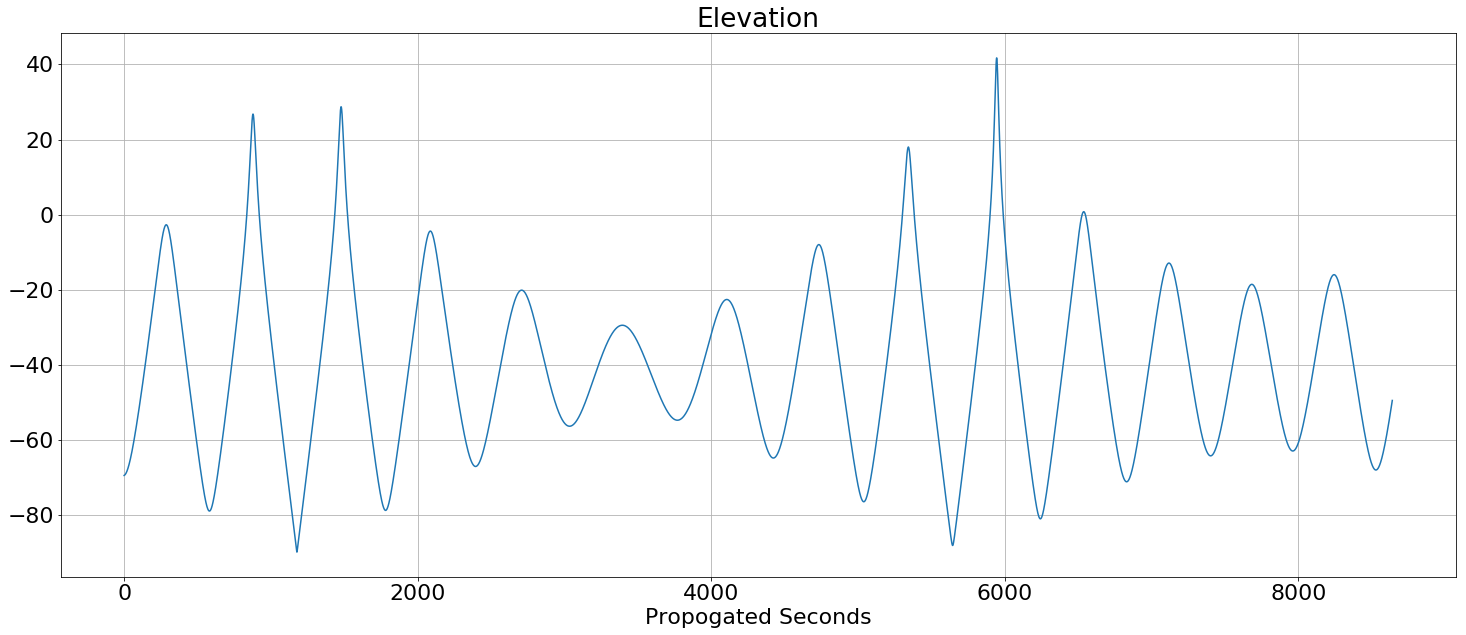

In [159]:
#plotting propogated elevation 
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(25,10))
plt.plot(elevation)
# ylim(0,90)
plt.xlabel('Propogated Seconds')
plt.title('Elevation')
plt.grid(True)

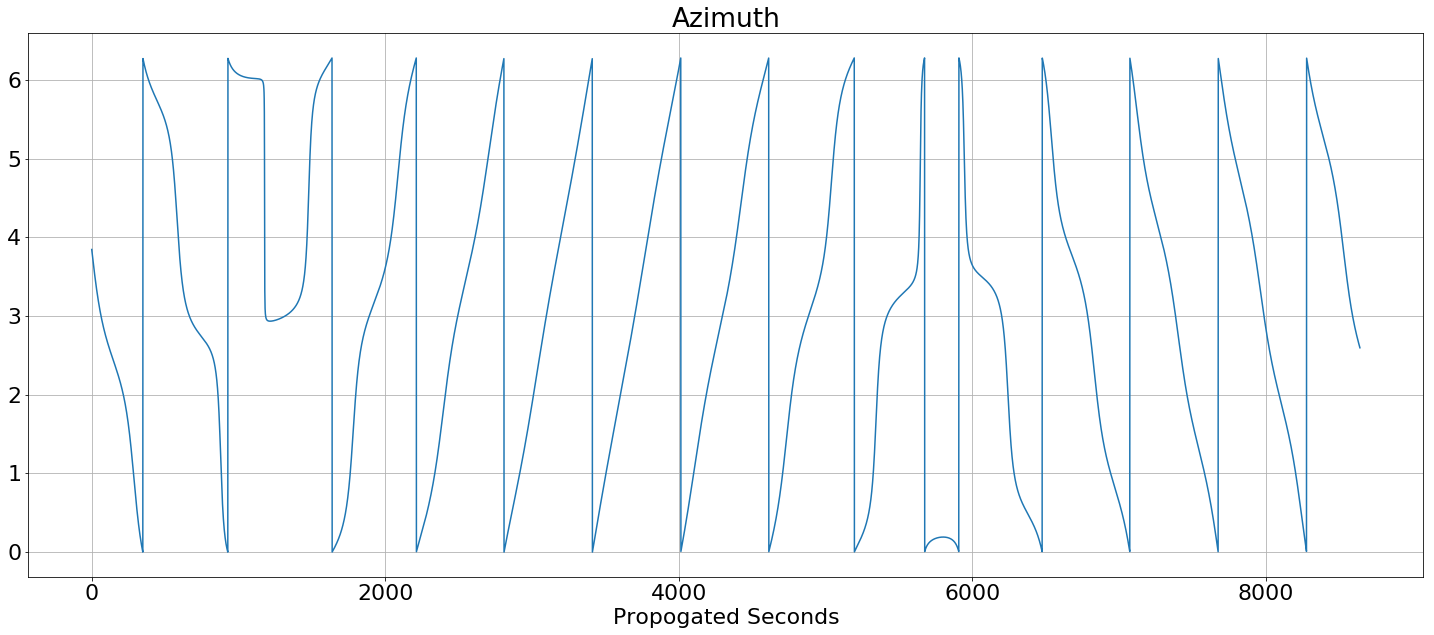

In [160]:
#plotting propogated azimuth 
plt.figure(figsize=(25,10))
plt.plot(azimuth)
# ylim(0,90)
plt.xlabel('Propogated Seconds')
plt.ylabel('')
plt.title('Azimuth')
plt.grid(True)

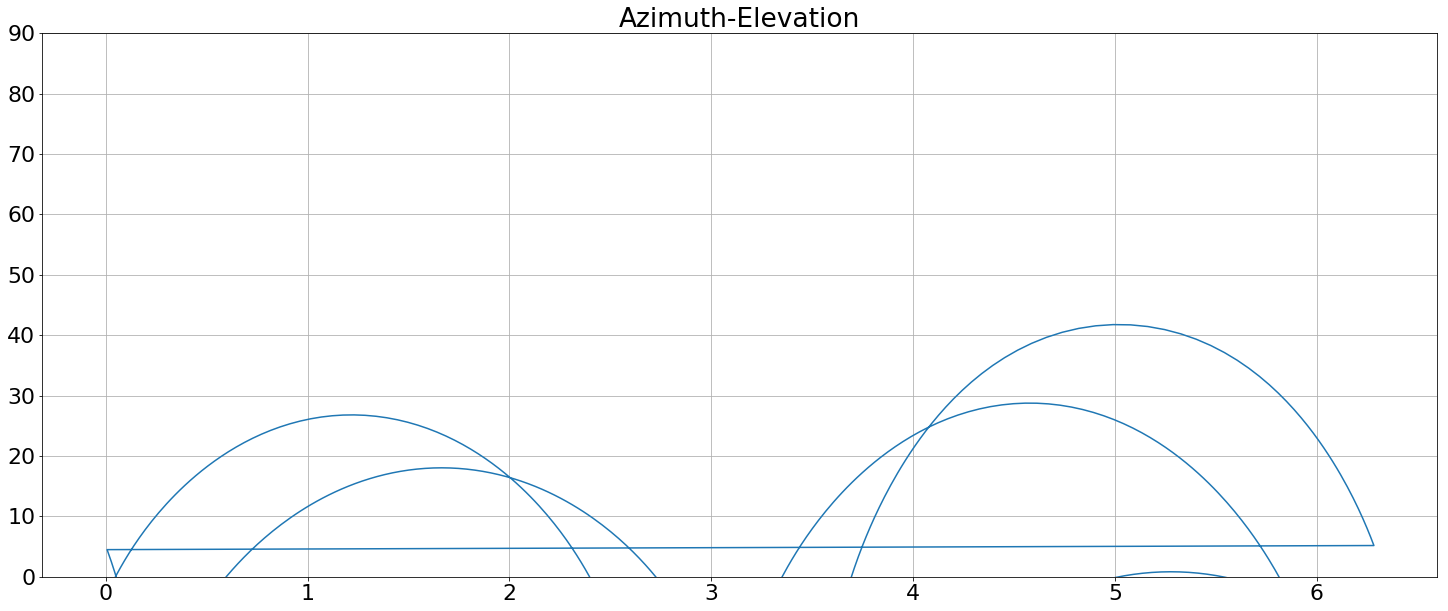

In [161]:
#plot the Azimuth and Elevation as the AZ-EL pair
plt.figure(figsize=(25,10))
plt.rcParams.update({'font.size': 22})
plt.plot(azimuth,elevation)
plt.ylim(0,90)
plt.title('Azimuth-Elevation')
plt.grid(True)

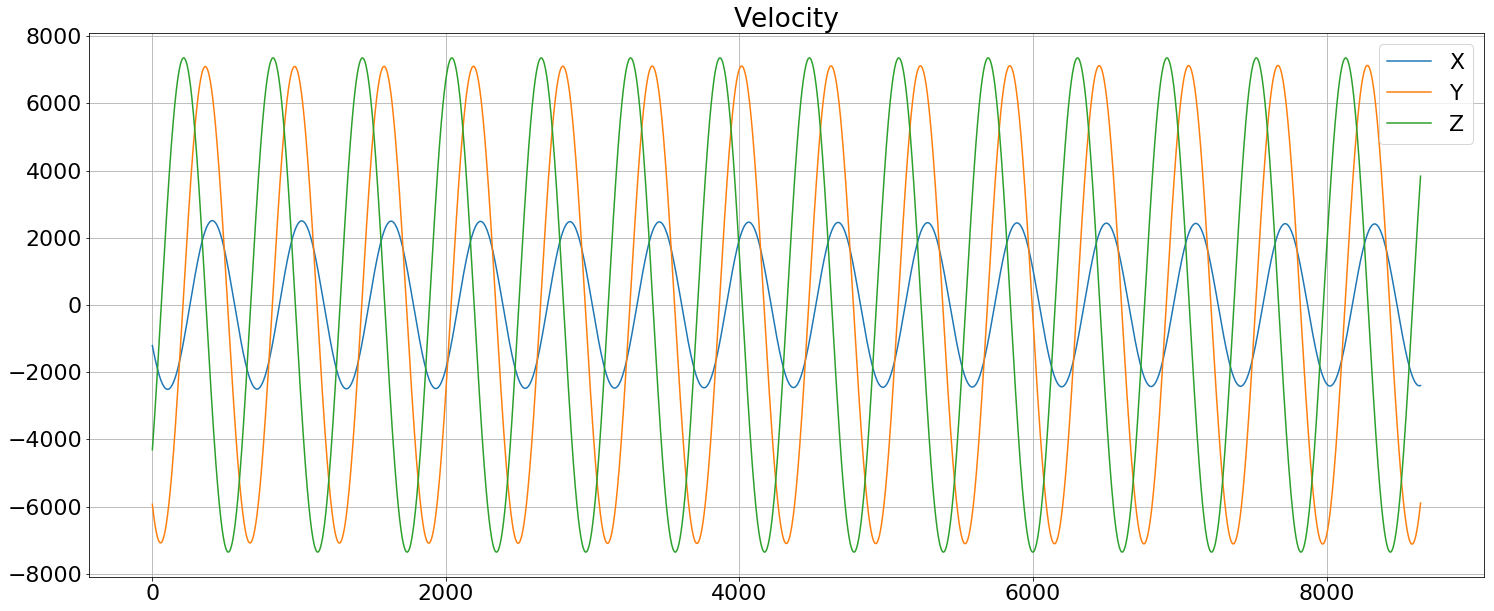

In [162]:
#plotting velocity

plt.figure(figsize=(25,10))
plt.rcParams.update({'font.size': 22})
plt.plot(velocity)
plt.title('Velocity')
plt.legend(['X', 'Y', 'Z'])
plt.grid(True)


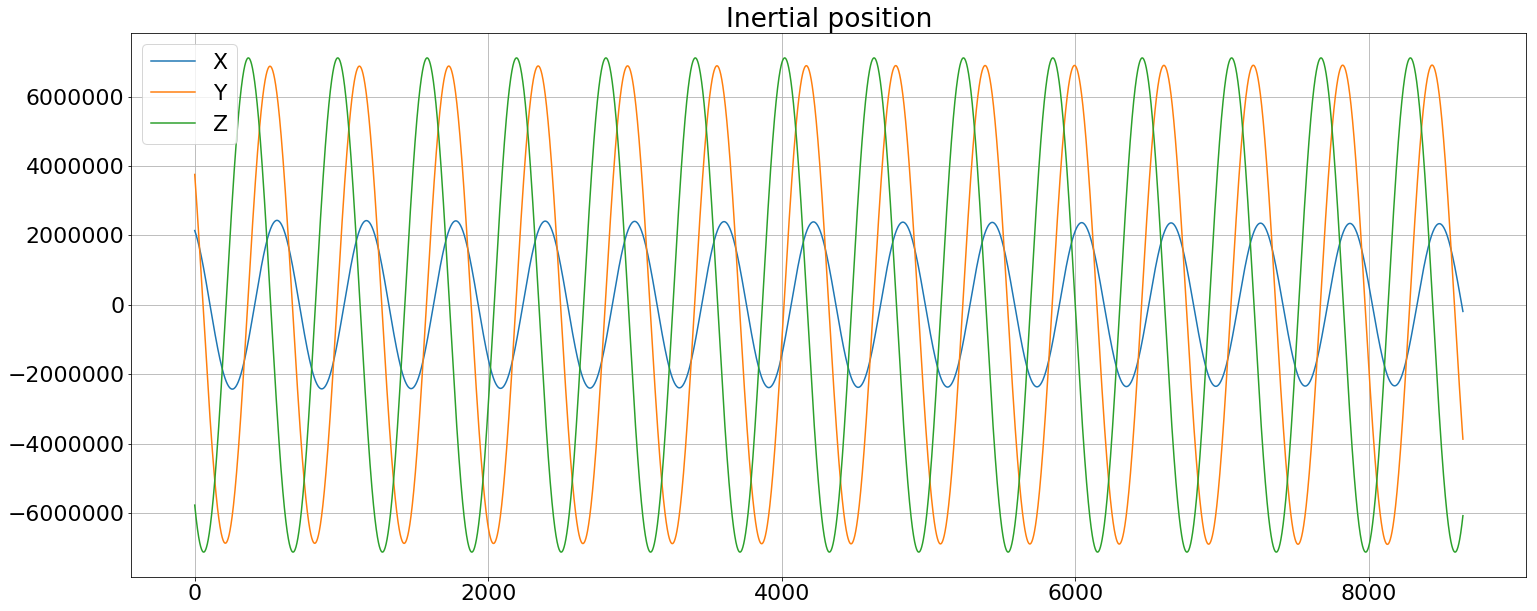

In [163]:
#plotting propogated position in 

plt.figure(figsize=(25,10))
plt.rcParams.update({'font.size': 22})
plt.plot(position) 
plt.title('Inertial position')
plt.grid(True)
plt.legend(['X', 'Y', 'Z'])
plt.show()



# Plot geographic position over earth of the propogated orbit 

AttributeError: can't set attribute

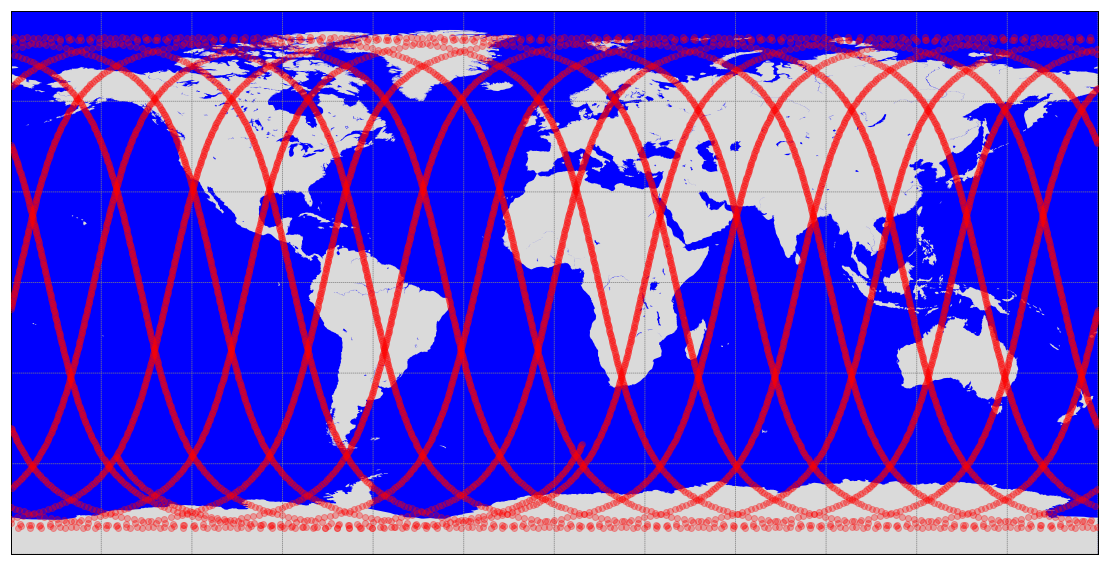

In [165]:
plt.figure(figsize=(25,10))

m = Basemap(projection='cyl',
            resolution='l',
            area_thresh=None)

m.drawmapboundary(fill_color='blue') #blue ocean 
m.fillcontinents(color='#dadada', lake_color='blue') #grey land and blue lakes 
m.drawmeridians(np.arange(-180, 180, 30), color='gray')
m.drawparallels(np.arange(-90, 90, 30), color='gray')

#scatter plot latitude and longitude points per epoch over (z order 3) earth projection map 
m.scatter(longitude, latitude, alpha=0.3, color='red', zorder=3)

# 3D interactive plot of propogated orbit around earth 


In [ ]:

#plot the orbit of the propogated TLE  
orbit = go.Scatter3d(
    x=pos_x, y=pos_y,z=pos_z,
    mode='markers',
    marker=dict(
        color='rgb(127, 127, 127)',
        size=2,
        symbol='circle'),
    name='Orbit')

#place a large blue scatter point in the centre of the frame to represent earth - not scaled. 
earth = go.Scatter3d(
    x=[0], y=[0], z=[0],
    mode='markers',
    marker=dict(
        size=70,
        opacity=1,
        color='rgb(0, 0, 128)'),
    name='Earth')

data = [orbit,earth]
layout = go.Layout(
    margin=dict(
        l=0, r=0, b=0, t=0),
     title='Propogated Orbit')

iplot(go.Figure(data=data, layout=layout))